#<font color='Green'>Assignment : Lstm On Donor Choose</font>

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



- For LSTM, you can choose your sequence padding methods on your own or you can train your LSTM without padding, there is no restriction on that.

### 1. Go through this blog, if you have any doubt on using predefined Embedding values in Embedding layer - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
### 2. Please go through this link https://keras.io/getting-started/functional-api-guide/ and check the 'Multi-input and multi-output models' then you will get to know how to give multiple inputs. 

In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Input , Dropout
from keras.layers import Flatten
from keras.layers import concatenate
from keras.layers.embeddings import Embedding
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import pickle
from keras.layers import LSTM
from keras.preprocessing.text import text_to_word_sequence
import tensorflow as tf
from keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau, EarlyStopping
from keras.layers import LayerNormalization
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from keras.regularizers import l2
from sklearn.metrics import roc_auc_score
from keras.models import load_model
from IPython.display import Image
from scipy.sparse import hstack
from keras.layers import Conv1D
from sklearn.feature_extraction.text import CountVectorizer
from prettytable import PrettyTable
from keras.preprocessing import sequence
from numpy import zeros
from keras import regularizers
from keras.layers import Conv1D
from keras.initializers import he_normal
from keras import optimizers

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
project_data  = pd.read_csv("/content/drive/MyDrive/Lstm on donor choose/preprocessed_data.csv")
project_data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [5]:
project_data.shape

(109248, 9)

In [6]:
x = project_data.drop(['project_is_approved'], axis = 1)
y = project_data['project_is_approved']

In [7]:
print(y.shape)
print(x.shape)

(109248,)
(109248, 8)


###splitting data

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)

print('Train Data Set', x_train.shape, y_train.shape)
print('Cross Validate Data Set', x_cv.shape, y_cv.shape)
print('Test Data Set', x_test.shape, y_test.shape)

Train Data Set (69918, 8) (69918,)
Cross Validate Data Set (17480, 8) (17480,)
Test Data Set (21850, 8) (21850,)


####Chaning type of dependent variable (y) to categorical type

In [9]:
from keras.utils import np_utils

#np_utils.to_categorical is used to convert array of labeled data(from 0 to nb_classes-1) to one-hot vector.

y_train = np_utils.to_categorical(y_train, 2)
y_test = np_utils.to_categorical(y_test, 2)
y_cv = np_utils.to_categorical(y_cv, 2)

In [10]:
y_cv.shape

(17480, 2)

In [11]:
print("Shape of x_train:", x_train.shape)
print("Shape of x_cv:", x_cv.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_cv:", y_cv.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (69918, 8)
Shape of x_cv: (17480, 8)
Shape of x_test: (21850, 8)
Shape of y_train: (69918, 2)
Shape of y_cv: (17480, 2)
Shape of y_test: (21850, 2)


In [ ]:
y_train.shape

(69918, 2)

##Encoding Text Data
###padding:
Padding document is to have the same input length of each document.

In [12]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
def encoding_padding(input_text, max_length):
    encoded_data = tokenizer.texts_to_sequences(input_text)
    padded_data = pad_sequences(encoded_data, maxlen=max_length, padding='post')
    return padded_data

Tokenize:


Input data to layer should be integer. So, using tokenize inbuilt function, we will integer encode the text data

In [13]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
train_text = x_train["essay"].values.tolist()
test_text = x_test['essay'].values.tolist()
val_text = x_cv['essay'].values.tolist()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text)
vocab_size = len(tokenizer.word_index) + 1

max_length = 400
train_text_encode = encoding_padding(train_text,  max_length=max_length)
test_text_encode = encoding_padding(test_text, max_length=max_length)
val_text_encode = encoding_padding(val_text, max_length=max_length)

print(train_text_encode.shape)
print(test_text_encode.shape)
print(val_text_encode.shape)

(69918, 400)
(21850, 400)
(17480, 400)


In [14]:
vocab_size

47363

###Weight Matrix

In [15]:
glove_vector = open("/content/drive/MyDrive/Lstm on donor choose/glove_vectors","rb")
glove_words = pickle.load(glove_vector)

In [16]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_words.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)
embedding_matrix[10]

(47363, 300)


array([-1.6509e-02,  2.6763e-01,  5.6118e-02,  3.7950e-02, -2.2509e-01,
        2.3450e-01, -3.7587e+00, -4.6558e-01,  8.9927e-03,  3.1239e-02,
        4.8702e-02, -1.0355e-01, -4.6802e-02, -4.9096e-01,  2.8895e-01,
        4.1719e-03, -2.9244e-02, -1.5100e-01, -5.9874e-02, -1.0642e-01,
        1.0236e-02,  8.6611e-02, -1.2328e-01,  5.8111e-02,  4.4774e-01,
        1.2824e-01,  1.0826e-01,  4.0072e-02, -2.9260e-01, -2.2230e-01,
       -5.2156e-01, -3.3644e-01,  2.5296e-01,  3.5089e-01, -1.1302e-01,
       -3.6476e-01, -2.6759e-01, -2.5142e-01,  9.1741e-02,  4.1009e-01,
       -1.1340e-01,  1.0475e-01, -5.5954e-01, -2.3784e-01,  4.0832e-01,
       -1.8500e-03,  7.7391e-02,  1.1396e-01,  3.6684e-01, -7.2937e-01,
        1.7876e-01, -4.1155e-01, -1.0766e-01, -3.1598e-01, -3.3749e-02,
       -1.7046e-01,  7.6821e-02,  5.3448e-02, -4.4717e-01, -1.8609e-01,
        3.1345e-02, -4.2470e-01,  2.8402e-01, -4.0830e-01, -4.1521e-01,
        2.2276e-02,  4.6234e-01, -1.1246e-01,  4.1678e-02, -3.09

In [17]:
train_text_encode.shape[1]

400

In [18]:
embedding_matrix.shape[1]

300

## 1. Embedded Layer For Input essay

In [19]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
#creating input layer
input_essay = Input(shape=(train_text_encode.shape[1],), name='input_essay')
#creating embedding layer
# This embedding layer will encode the input sequence
# into a sequence of dense 300-dimensional vectors.
x1 =Embedding(input_dim=vocab_size, output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], input_length=train_text_encode.shape[1], trainable=False, name='embed_essay')(input_essay)
#creating lstm layer
x1 = LSTM(128,kernel_regularizer=l2(0.001),return_sequences=True)(x1)

layer_1 = Flatten()(x1)

###Categorical Feature:
1-Teacher prefix

In [20]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train["teacher_prefix"].values.tolist())

print('-'*50)
# This embedding layer will encode the input sequence

#embedding_layer = Embedding(input, output_dim, weights=[embedding_matrix],input_length=max_length, trainable=False)
input_prefix = Input(shape=(1,),name="teacher_prefix")
x2 = Embedding(input_dim=52, output_dim=min(52//2,50), name="embed_prefix", trainable=True)(input_prefix)
layer_2 = Flatten()(x2)

train_prefix_encode = encoding_padding(x_train["teacher_prefix"], max_length=1)
test_prefix_encode = encoding_padding(x_test["teacher_prefix"], max_length=1)
val_prefix_encode = encoding_padding(x_cv["teacher_prefix"], max_length=1)

print(train_prefix_encode.shape)
print(test_prefix_encode.shape)
print(val_prefix_encode.shape)

--------------------------------------------------
(69918, 1)
(21850, 1)
(17480, 1)


2-school state

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train["school_state"].values.tolist())

print('-'*50)
input_state = Input(shape=(1,),name="school_state")
x3 = Embedding(input_dim=52, output_dim=min(52//2,50), name="embed_state", trainable=True)(input_state)
layer_3 = Flatten()(x3)

train_state_encode = encoding_padding(x_train["school_state"], max_length=1)
test_state_encode = encoding_padding(x_test["school_state"], max_length=1)
val_state_encode = encoding_padding(x_cv["school_state"], max_length=1)

print(train_state_encode.shape)
print(test_state_encode.shape)
print(val_state_encode.shape)

--------------------------------------------------
(69918, 1)
(21850, 1)
(17480, 1)


3- project garde category 

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train["project_grade_category"].values.tolist())

print('-'*50)

input_grade = Input(shape=(1,),name="grade")
x4 = Embedding(input_dim=52, output_dim=min(52//2,50), name="embed_grade", trainable=True)(input_grade)
layer_4 = Flatten()(x4)

train_grade_encode = encoding_padding(x_train["project_grade_category"], max_length=1)
test_grade_encode = encoding_padding(x_test["project_grade_category"], max_length=1)
val_grade_encode = encoding_padding(x_cv["project_grade_category"], max_length=1)

print(train_grade_encode.shape)
print(test_grade_encode.shape)
print(val_grade_encode.shape)

--------------------------------------------------
(69918, 1)
(21850, 1)
(17480, 1)


4- clean categories

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train["clean_categories"].values.tolist())

print('-'*50)

input_cat= Input(shape=(1,),name="clean_categories")
x5 = Embedding(input_dim=52, output_dim=min(52//2,50), name="embed_cat", trainable=True)(input_cat)
layer_5 = Flatten()(x5)

train_cat_encode = encoding_padding(x_train["clean_categories"], max_length=1)
test_cat_encode = encoding_padding(x_test["clean_categories"], max_length=1)
val_cat_encode = encoding_padding(x_cv["clean_categories"], max_length=1)

print(train_cat_encode.shape)
print(test_cat_encode.shape)
print(val_cat_encode.shape)

--------------------------------------------------
(69918, 1)
(21850, 1)
(17480, 1)



5-clean sub categories




In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train["clean_subcategories"].values.tolist())

print('-'*50)

input_subcat= Input(shape=(1,),name="subject_subcategories")
x6 = Embedding(input_dim=384 , output_dim=min(384//2,50), name="embed_subcat", trainable=True)(input_subcat)
layer_6 = Flatten()(x6)

train_subcat_encode = encoding_padding(x_train["clean_subcategories"], max_length=1)
test_subcat_encode = encoding_padding(x_test["clean_subcategories"], max_length=1)
val_subcat_encode = encoding_padding(x_cv["clean_subcategories"], max_length=1)

print(train_subcat_encode.shape)
print(test_subcat_encode.shape)
print(val_subcat_encode.shape)

--------------------------------------------------
(69918, 1)
(21850, 1)
(17480, 1)


## Numerical Features
We will reshape the numerical features to (-1, 1). Then concatenate numerical features and standardize the final output.
- price
- teacher number of previously project

In [25]:
train_remaining_input = np.concatenate((x_train['price'].values.reshape(-1,1),
                                  x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)),axis=1)

test_remaining_input = np.concatenate((x_test['price'].values.reshape(-1,1),
                                  x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)),axis=1)

val_remaining_input = np.concatenate((x_cv['price'].values.reshape(-1,1),
                                  x_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)), axis=1)

print(train_remaining_input.shape)
print(test_remaining_input.shape)
print(val_remaining_input.shape)

(69918, 2)
(21850, 2)
(17480, 2)



Standardizing Numerical Features

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_rem_input = scaler.fit_transform(train_remaining_input)
test_rem_input = scaler.transform(test_remaining_input)
val_rem_input = scaler.transform(val_remaining_input)

num_feats = Input(shape=(2,), name="numerical_features")
layer_7 = Dense(64,activation="relu",kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(num_feats)

print(train_rem_input.shape)
print(test_rem_input.shape)
print(val_rem_input.shape)

(69918, 2)
(21850, 2)
(17480, 2)


In [27]:
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Input , Dropout
from keras.layers import Flatten
from keras.layers import concatenate
from keras.layers.embeddings import Embedding
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import pickle
from keras.layers import LSTM
from keras.preprocessing.text import text_to_word_sequence
import tensorflow as tf
from keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, BatchNormalization
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from keras.regularizers import l2
from sklearn.metrics import roc_auc_score
from keras.models import load_model
from IPython.display import Image
from scipy.sparse import hstack
from keras.layers import Conv1D
from sklearn.feature_extraction.text import CountVectorizer
from prettytable import PrettyTable
from keras.preprocessing import sequence
from numpy import zeros
from keras import regularizers
from keras.layers import Conv1D
from keras.initializers import he_normal
from keras import optimizers

## <span style='font-family:Helvetica'> Concatenating all the flattened layers.

In [28]:
x_concat = concatenate([layer_1, layer_2, layer_3, layer_4, layer_5, layer_6, layer_7])

#<font color='red'>Keras Model-1.1</font>

- Activation :  {  hidden_layer : relu , output_layer : softmax  }
- optimizer :   { 'Adam'}
- loss      :   { 'categorical_crossentropy' }
- Batch_size :  {512}
- epoch      :  {10}

In [ ]:
x = Dense(500,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x_concat)
x = Dropout(0.5)(x)
x = Dense(250,activation="relu",kernel_initializer="glorot_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(100,activation="relu", kernel_initializer="glorot_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.4)(x)
x = Dense(50,activation="relu", kernel_initializer="glorot_normal",kernel_regularizer=regularizers.l2(0.001))(x)

output = Dense(2, activation='softmax', name='Output')(x)

model_1 = Model(inputs=[input_essay, input_state ,input_prefix,input_cat,
                       input_subcat ,input_grade ,num_feats ],outputs=[output])

print(model_1.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_essay (InputLayer)        [(None, 400)]        0                                            
__________________________________________________________________________________________________
embed_essay (Embedding)         (None, 400, 300)     14233500    input_essay[0][0]                
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
school_state (InputLayer)       [(None, 1)]          0                                            
______________________________________________________________________________________________

<font color='Black'>Getting all data into list</font>

In [ ]:
#Getting all data into list
#for train data
train_data = [train_text_encode, train_prefix_encode, train_state_encode, train_grade_encode,
              train_cat_encode, train_subcat_encode, train_rem_input]
#for test data
test_data = [test_text_encode, test_prefix_encode, test_state_encode, test_grade_encode,
             test_cat_encode, test_subcat_encode, test_rem_input]
#for val data
val_data = [val_text_encode, val_prefix_encode, val_state_encode, val_grade_encode,
            val_cat_encode, val_subcat_encode, val_rem_input]

In [ ]:
y_train.shape

(69918, 2)

<font color='Black'>Network Artitecture</font>

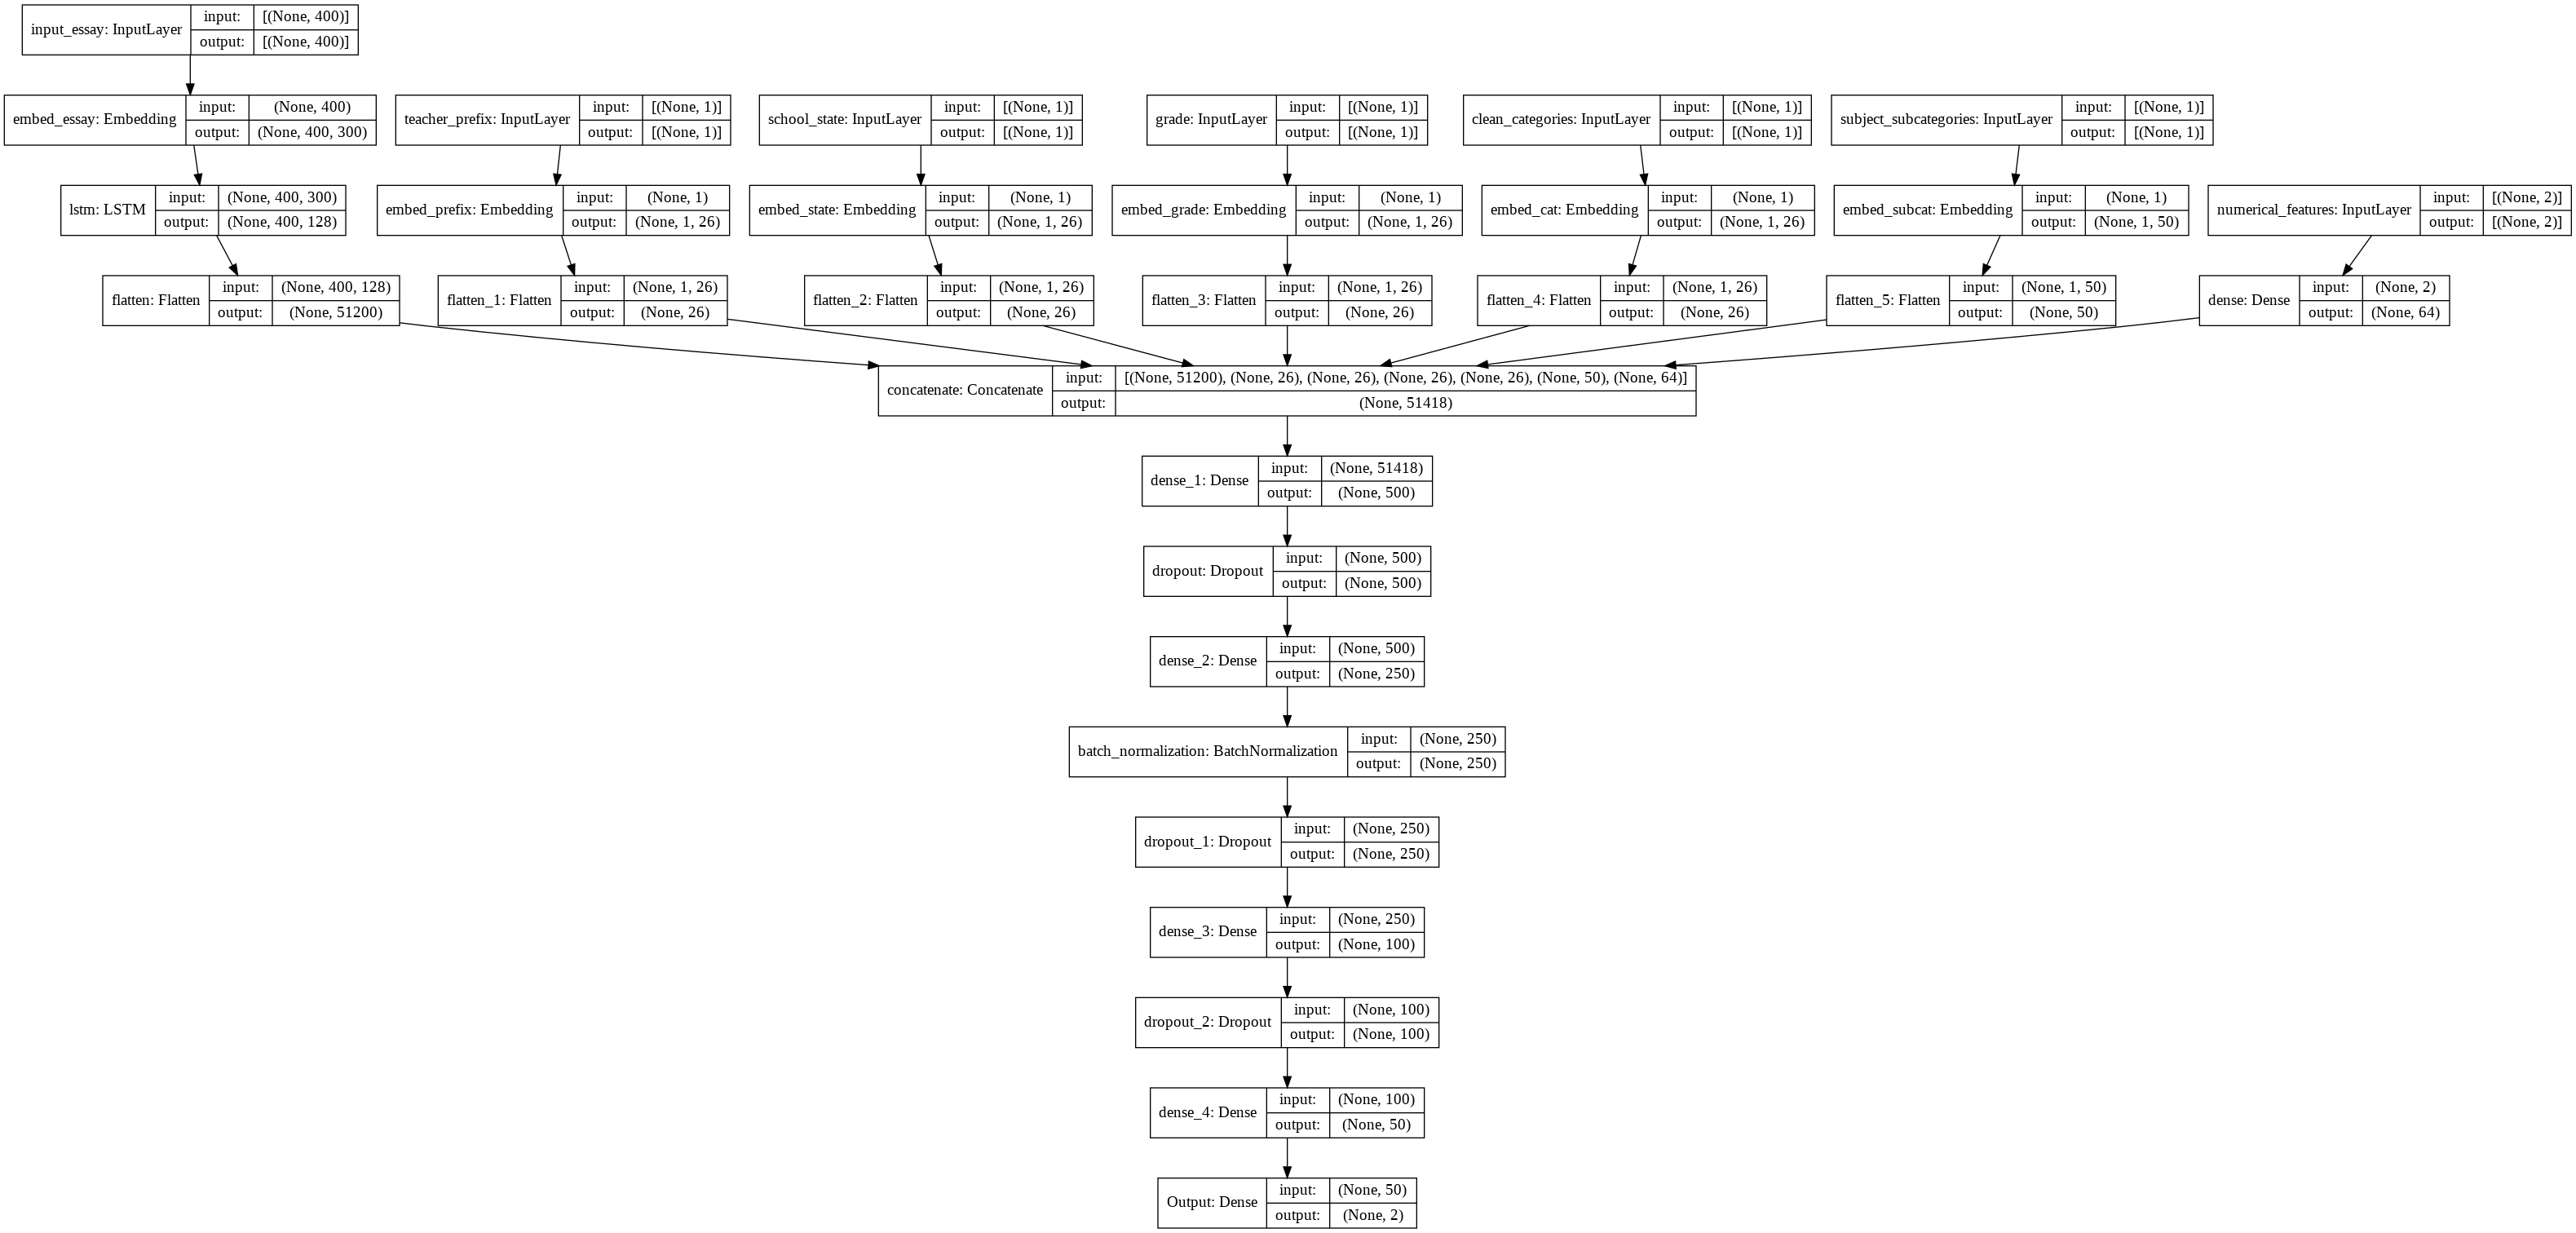

In [ ]:
# https://github.com/mmortazavi/EntityEmbedding-Working_Example/blob/master/EntityEmbedding.ipynb

import pydot_ng as pydot
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model_1, show_shapes = True, show_layer_names = True, to_file = 'model_1.png')

Image(retina = True, filename = 'model_1.png')

AUC-ROC custom function

In [ ]:
from sklearn.metrics import roc_auc_score

import tensorflow as tf

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

Creating Callback with Checkpoint, EarlyStopping and Tensorboard

In [ ]:
checkpoint1 = ModelCheckpoint("model_1.h5",
                             monitor="val_auroc",
                             mode="max",
                             save_best_only = True,
                             verbose=1)
earlystop1 = EarlyStopping(monitor = 'val_auroc', 
                            mode="max",
                            min_delta = 0, 
                            patience = 3,
                            verbose = 1)

tensorboard1 = TensorBoard(log_dir='Model1_visualization')

callbacks_1 = [checkpoint1,earlystop1,tensorboard1]

In [ ]:
from tensorflow.keras.optimizers import Adam
model_1.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = [auroc])

In [ ]:
history = model_1.fit(train_data, y_train, batch_size=512,epochs = 10, verbose=1,callbacks=callbacks_1, validation_data=(val_data, y_cv))

Epoch 1/10
137/137 [==============================] - 790s 6s/step - loss: 1.2642 - auroc: 0.6249 - val_loss: 1.2124 - val_auroc: 0.7043

Epoch 00001: val_auroc improved from -inf to 0.70428, saving model to model_1.h5
Epoch 2/10
137/137 [==============================] - 702s 5s/step - loss: 0.9345 - auroc: 0.6939 - val_loss: 1.0219 - val_auroc: 0.7251

Epoch 00002: val_auroc improved from 0.70428 to 0.72512, saving model to model_1.h5
Epoch 3/10
137/137 [==============================] - 722s 5s/step - loss: 0.7901 - auroc: 0.7154 - val_loss: 0.9542 - val_auroc: 0.7400

Epoch 00003: val_auroc improved from 0.72512 to 0.73998, saving model to model_1.h5
Epoch 4/10
137/137 [==============================] - 701s 5s/step - loss: 0.7039 - auroc: 0.7288 - val_loss: 0.7329 - val_auroc: 0.7385

Epoch 00004: val_auroc did not improve from 0.73998
Epoch 5/10
137/137 [==============================] - 722s 5s/step - loss: 0.6326 - auroc: 0.7378 - val_loss: 0.7354 - val_auroc: 0.7481

Epoch 000

<font color='red'>Plot loss vs epoch</font>

In [ ]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

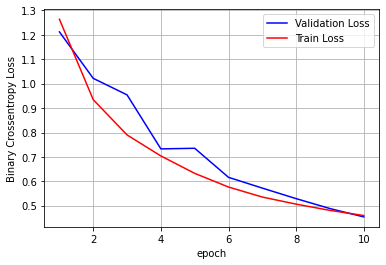

In [ ]:
%matplotlib inline
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')
x = list(range(1,11))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

#observation:
We can see that at first both the training and validation losses are decreasing but after epoch reaches to 5 validation loss remain constant for sometimes and again it's decrease but training loss keeps on decreasing without any constant.

<font color='red'>Evaluating test data</font>

43/43 [==============================] - 78s 2s/step - loss: 0.4525 - auroc: 0.7566
Test Loss: 0.45246291160583496
Test ROC-AUC score: 0.7566255331039429 



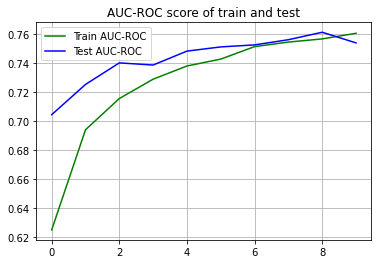

In [ ]:
# Evaluating test data
score_1 = model_1.evaluate(test_data, y_test, verbose = 1, batch_size = 512)
print('Test Loss:', score_1[0])
print('Test ROC-AUC score:', score_1[1], '\n')

# Plotting train and test auc roc score
plt.plot(history.history['auroc'], 'g')
plt.plot(history.history['val_auroc'], 'b')
plt.title("AUC-ROC score of train and test")
plt.legend({'Train AUC-ROC': 'g', 'Test AUC-ROC':'b'})
plt.grid()
plt.show()

##Observation:
- Test Loss - 0.4524
- Test AUC-ROC - 0.7566

#<font color='RED'>Keras Model-1.2</font>

- Activation :  {  hidden_layer : relu , output_layer : softmax  }same as model_1 but slightly different hidden layer number 
- optimizer :   { 'Adam'}
- loss      :   { 'categorical_crossentropy' }
- Batch_size :  {256}
- epoch      :  {10}

In [ ]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
#creating input layer
input_essay = Input(shape=(train_text_encode.shape[1],), name='input_essay')
#creating embedding layer
# This embedding layer will encode the input sequence
# into a sequence of dense 324-dimensional vectors.
x1 =Embedding(input_dim=vocab_size, output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], input_length=train_text_encode.shape[1], trainable=False, name='embed_essay')(input_essay)
#creating lstm layer
x1 = LSTM(100, activation = 'relu',kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(x1)

layer_1 = Flatten()(x1)

In [ ]:
x_concat = concatenate([layer_1, layer_2, layer_3, layer_4, layer_5, layer_6, layer_7])

In [ ]:
x = Dense(512,activation="relu", kernel_initializer="he_normal",kernel_regularizer=regularizers.l2(0.001))(x_concat)
x = Dropout(0.5)(x)
x = Dense(256,activation="relu",kernel_initializer="glorot_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128,activation="relu", kernel_initializer="glorot_normal",kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.4)(x)
x = Dense(50,activation="relu", kernel_initializer="glorot_normal",kernel_regularizer=regularizers.l2(0.001))(x)

output = Dense(2, activation='softmax', name='Output')(x)

model_1 = Model(inputs=[input_essay, input_state ,input_prefix,input_cat,
                       input_subcat ,input_grade ,num_feats ],outputs=[output])

print(model_1.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_essay (InputLayer)        [(None, 300)]        0                                            
__________________________________________________________________________________________________
embed_essay (Embedding)         (None, 300, 300)     14217600    input_essay[0][0]                
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
school_state (InputLayer)       [(None, 1)]          0                                            
______________________________________________________________________________________________

In [ ]:
#Getting all data into list
#for train data
train_data = [train_text_encode, train_prefix_encode, train_state_encode, train_grade_encode,
              train_cat_encode, train_subcat_encode, train_rem_input]
#for test data
test_data = [test_text_encode, test_prefix_encode, test_state_encode, test_grade_encode,
             test_cat_encode, test_subcat_encode, test_rem_input]
#for val data
val_data = [val_text_encode, val_prefix_encode, val_state_encode, val_grade_encode,
            val_cat_encode, val_subcat_encode, val_rem_input]

In [ ]:
train_rem_input.shape

(69918, 2)

Network arcitecture:


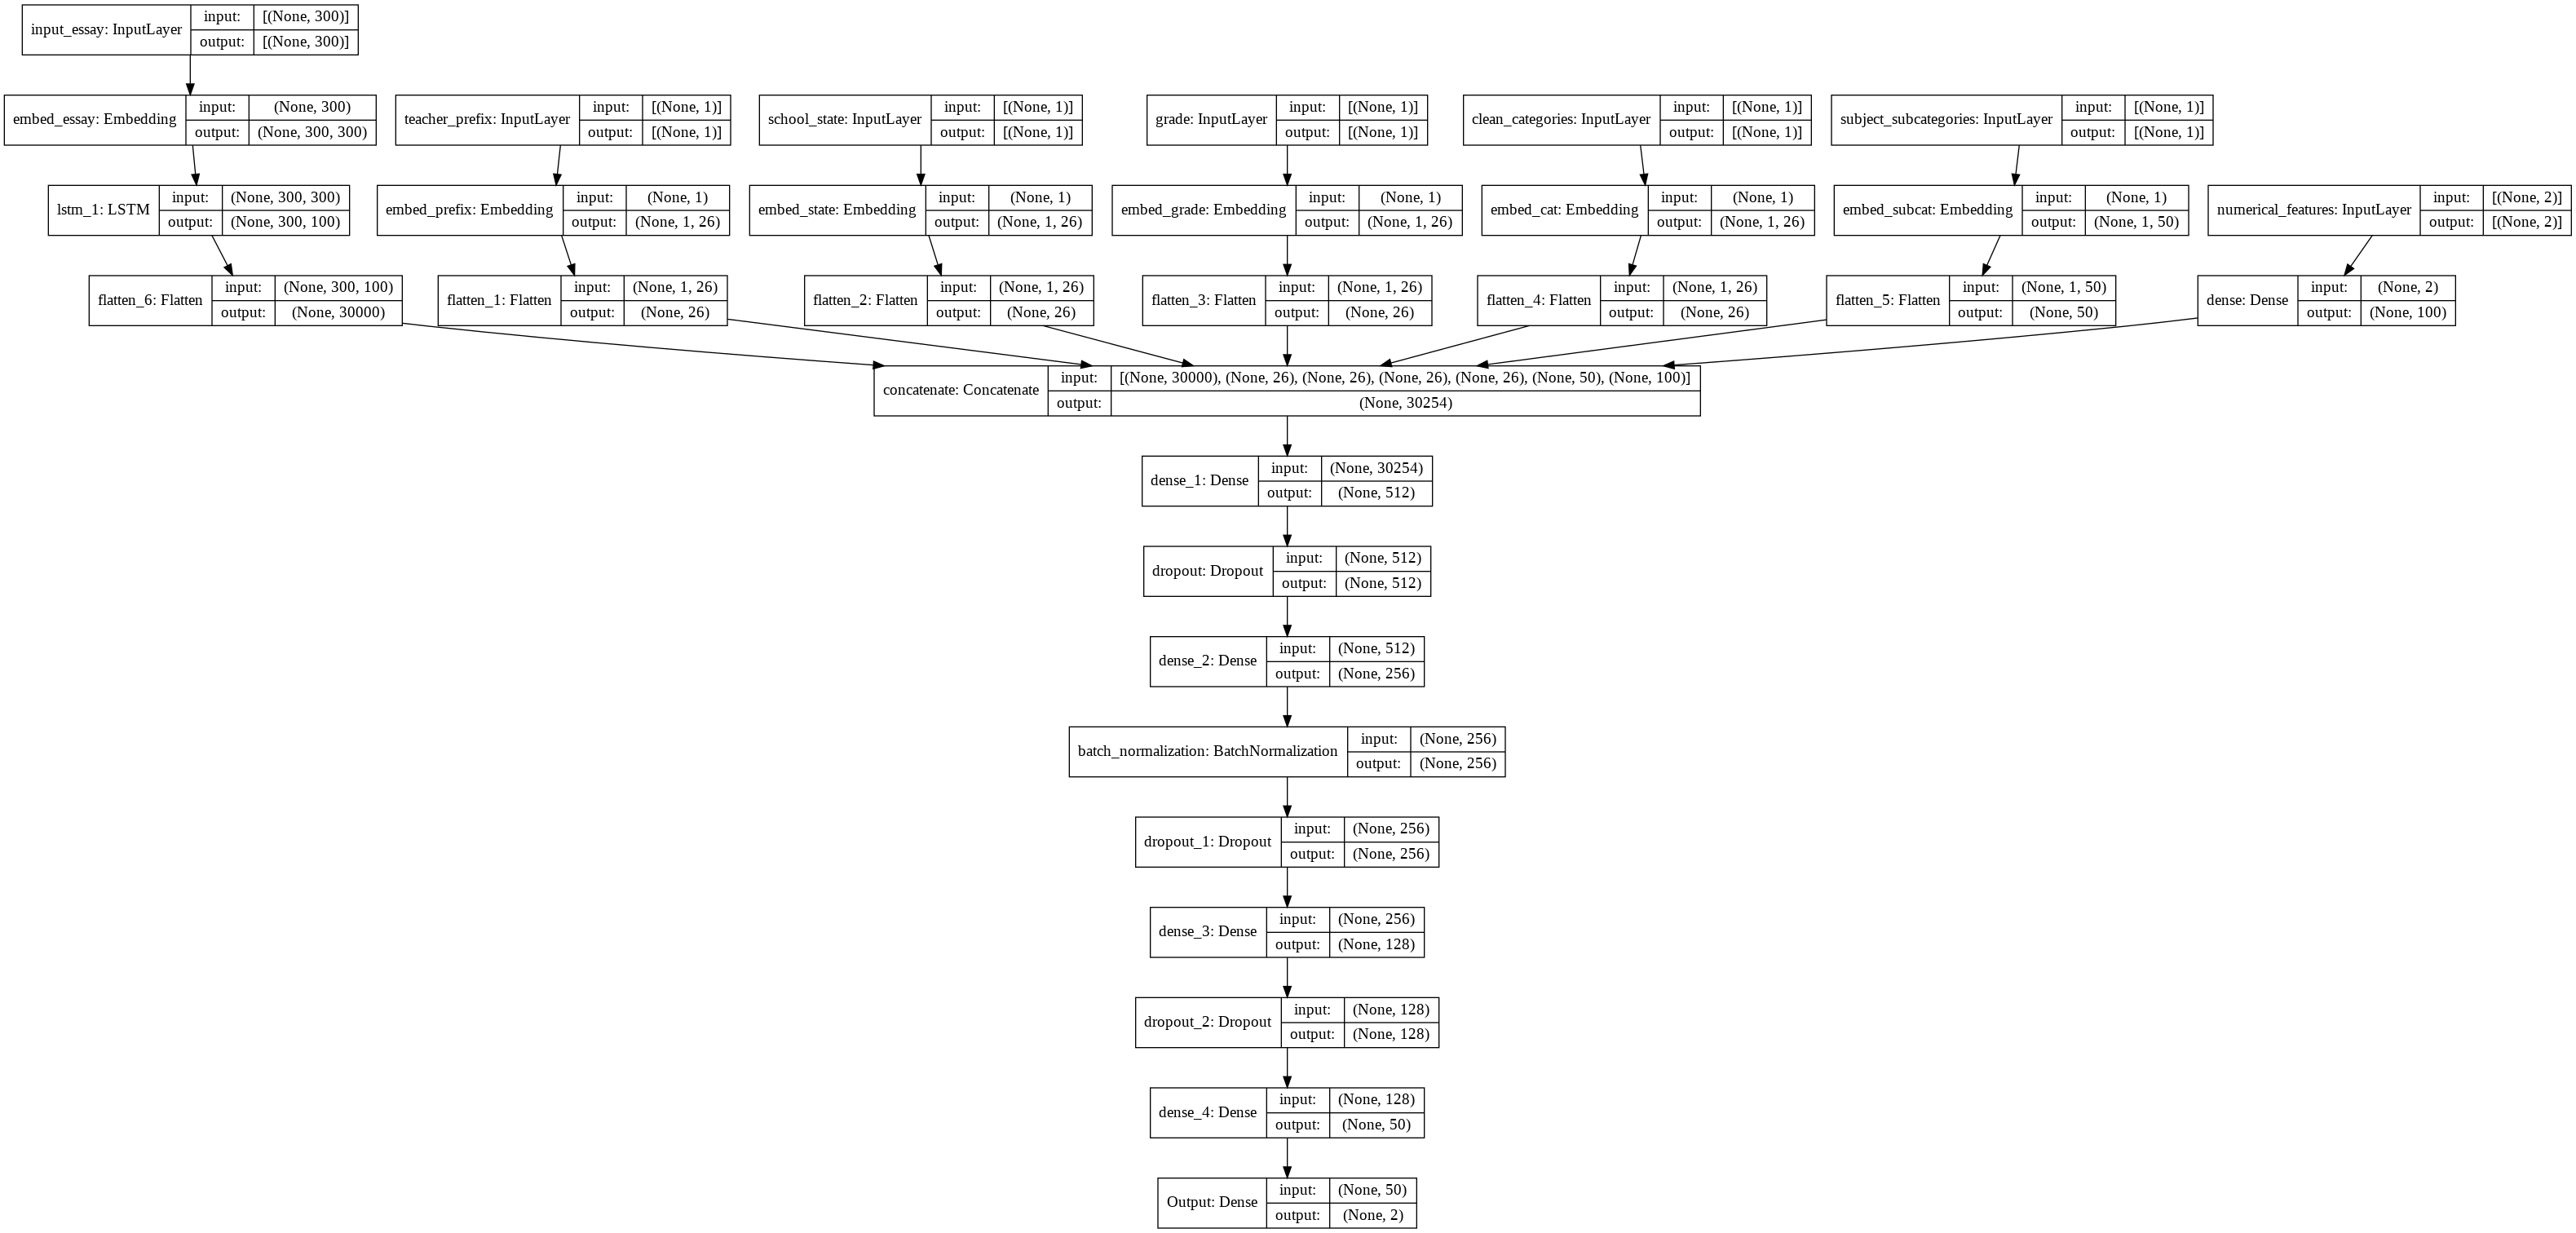

In [ ]:
# https://github.com/mmortazavi/EntityEmbedding-Working_Example/blob/master/EntityEmbedding.ipynb

import pydot_ng as pydot
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model_1, show_shapes = True, show_layer_names = True, to_file = 'model_1.png')

Image(retina = True, filename = 'model_1.png')

Custom Callback :

In [ ]:
checkpoint1 = ModelCheckpoint("model_1.h5",
                             monitor="val_auroc",
                             mode="max",
                             save_best_only = True,
                             verbose=1)
earlystop1 = EarlyStopping(monitor = 'val_auroc', 
                            mode="max",
                            min_delta = 0, 
                            patience = 2,
                            verbose = 1)

tensorboard1 = TensorBoard(log_dir='Model1_visualization')

callbacks_1 = [checkpoint1,earlystop1,tensorboard1]

In [ ]:
from tensorflow.keras.optimizers import Adam
model_1.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = [auroc])

In [ ]:
history = model_1.fit(train_data, y_train, batch_size=256,epochs = 10, verbose=1,callbacks=callbacks_1, validation_data=(val_data, y_cv))

Epoch 1/10
274/274 [==============================] - 689s 3s/step - loss: 1.4726 - auroc: 0.5382 - val_loss: 1.2149 - val_auroc: 0.4697

Epoch 00001: val_auroc improved from -inf to 0.46973, saving model to model_1.h5
Epoch 2/10
274/274 [==============================] - 647s 2s/step - loss: 0.9344 - auroc: 0.5617 - val_loss: 0.9650 - val_auroc: 0.6097

Epoch 00002: val_auroc improved from 0.46973 to 0.60970, saving model to model_1.h5
Epoch 3/10
274/274 [==============================] - 673s 2s/step - loss: 0.7922 - auroc: 0.5807 - val_loss: 0.8209 - val_auroc: 0.6285

Epoch 00003: val_auroc improved from 0.60970 to 0.62846, saving model to model_1.h5
Epoch 4/10
274/274 [==============================] - 666s 2s/step - loss: 0.7118 - auroc: 0.5976 - val_loss: 0.7361 - val_auroc: 0.5870

Epoch 00004: val_auroc did not improve from 0.62846
Epoch 5/10
274/274 [==============================] - 666s 2s/step - loss: 0.6632 - auroc: 0.5995 - val_loss: 0.6846 - val_auroc: 0.5100

Epoch 000

<font color='red'>Plot loss vs epoch</font>

In [ ]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

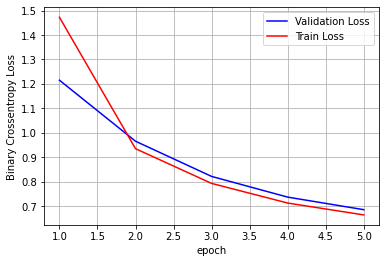

In [ ]:
%matplotlib inline
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')
x = list(range(1,6))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

<font color='red'>evaliting test data</font>

86/86 [==============================] - 67s 778ms/step - loss: 0.6846 - auroc: 0.5064
Test Loss: 0.684643030166626
Test ROC-AUC score: 0.5064215660095215 



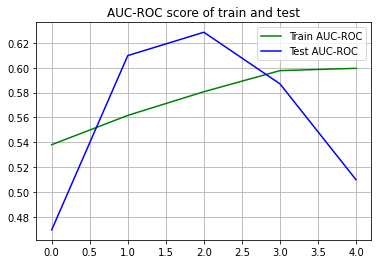

In [ ]:
# Evaluating test data
score_1 = model_1.evaluate(test_data, y_test, verbose = 1, batch_size = 256)
print('Test Loss:', score_1[0])
print('Test ROC-AUC score:', score_1[1], '\n')

# Plotting train and test auc roc score
plt.plot(history.history['auroc'], 'g')
plt.plot(history.history['val_auroc'], 'b')
plt.title("AUC-ROC score of train and test")
plt.legend({'Train AUC-ROC': 'g', 'Test AUC-ROC':'b'})
plt.grid()
plt.show()

#<font color='red'>Keras Model-1.3</font>

- Activation :  {  hidden_layer : by_default , output_layer : softmax  }with different hidden layer number
- optimizer :   { 'Adam'}
- loss      :   { 'categorical_crossentropy' }
- Batch_size :  {800}
- epoch      :  {10}

In [ ]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
#creating input layer
input_essay = Input(shape=(train_text_encode.shape[1],), name='input_essay')
#creating embedding layer
# This embedding layer will encode the input sequence
# into a sequence of dense 324-dimensional vectors.
x1 =Embedding(input_dim=vocab_size, output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], input_length=train_text_encode.shape[1], trainable=False, name='embed_essay')(input_essay)
#creating lstm layer
x1 = LSTM(100, activation = 'relu',kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(x1)

layer_1 = Flatten()(x1)

In [ ]:
x_concat = concatenate([layer_1, layer_2, layer_3, layer_4, layer_5, layer_6, layer_7])

In [ ]:
#After concatenating text input, categorical and remaining numerical features, applying it to the model
from keras.layers import Concatenate
x= Dense(256,kernel_initializer='glorot_normal',kernel_regularizer=l2(0.002))(x_concat)
x= Dropout(0.6)(x)
x= Dense(128,kernel_initializer='glorot_normal',kernel_regularizer=l2(0.002))(x)
x= Dropout(0.5)(x)
x= Dense(64,kernel_initializer='glorot_normal',kernel_regularizer=l2(0.002))(x)
x= Dropout(0.5)(x)
x= Dense(32,kernel_initializer='glorot_normal',kernel_regularizer=l2(0.002))(x)
x= Dropout(0.5)(x)
x= Dense(16,activation='relu',kernel_initializer='glorot_normal',kernel_regularizer=l2(0.002))(x)
output = Dense(2, activation='softmax', name='Output')(x)
model_1 = Model(inputs=[input_essay, input_state ,input_prefix,input_cat,
                       input_subcat ,input_grade ,num_feats ],outputs=[output])

print(model_1.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_essay (InputLayer)        [(None, 400)]        0                                            
__________________________________________________________________________________________________
embed_essay (Embedding)         (None, 400, 300)     14174100    input_essay[0][0]                
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
school_state (InputLayer)       [(None, 1)]          0                                            
______________________________________________________________________________________________

custom callback :

In [ ]:
checkpoint1 = ModelCheckpoint("model_1.h5",
                             monitor="val_auroc",
                             mode="max",
                             save_best_only = True,
                             verbose=1)
earlystop1 = EarlyStopping(monitor = 'val_auroc', 
                            mode="max",
                            min_delta = 0, 
                            patience = 2,
                            verbose = 1)

tensorboard1 = TensorBoard(log_dir='Model1_visualization')

callbacks_1 = [checkpoint1,earlystop1,tensorboard1]

In [ ]:
from tensorflow.keras.optimizers import Adam
model_1.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = [auroc])

In [ ]:
history = model_1.fit(train_data, y_train, batch_size=800,epochs = 10, verbose=1,callbacks=callbacks_1, validation_data=(val_data, y_cv))

Epoch 1/10
88/88 [==============================] - 934s 11s/step - loss: 2.0723 - auroc: 0.6062 - val_loss: 1.8347 - val_auroc: 0.6974

Epoch 00001: val_auroc improved from -inf to 0.69744, saving model to model_1.h5
Epoch 2/10
88/88 [==============================] - 922s 10s/step - loss: 1.6982 - auroc: 0.6400 - val_loss: 1.5432 - val_auroc: 0.7087

Epoch 00002: val_auroc improved from 0.69744 to 0.70866, saving model to model_1.h5
Epoch 3/10
88/88 [==============================] - 911s 10s/step - loss: 1.4567 - auroc: 0.6712 - val_loss: 1.3582 - val_auroc: 0.7160

Epoch 00003: val_auroc improved from 0.70866 to 0.71597, saving model to model_1.h5
Epoch 4/10
88/88 [==============================] - 915s 10s/step - loss: 1.2952 - auroc: 0.6881 - val_loss: 1.2268 - val_auroc: 0.7206

Epoch 00004: val_auroc improved from 0.71597 to 0.72062, saving model to model_1.h5
Epoch 5/10
88/88 [==============================] - 920s 10s/step - loss: 1.1821 - auroc: 0.7070 - val_loss: 1.1370 - v

<font color='red'>Plot loss vs epoch</font>

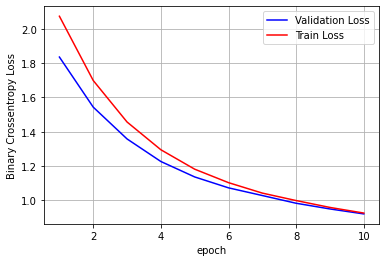

In [ ]:
%matplotlib inline
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')
x = list(range(1,11))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

<font color='red'>auc-roc score</font>

28/28 [==============================] - 103s 4s/step - loss: 0.9231 - auroc: 0.7278
Test Loss: 0.9231275916099548
Test ROC-AUC score: 0.7277827858924866 



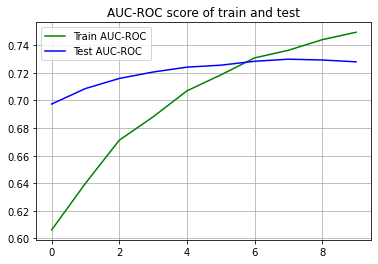

In [ ]:
# Evaluating test data
score_1 = model_1.evaluate(test_data, y_test, verbose = 1, batch_size = 800)
print('Test Loss:', score_1[0])
print('Test ROC-AUC score:', score_1[1], '\n')

# Plotting train and test auc roc score
plt.plot(history.history['auroc'], 'g')
plt.plot(history.history['val_auroc'], 'b')
plt.title("AUC-ROC score of train and test")
plt.legend({'Train AUC-ROC': 'g', 'Test AUC-ROC':'b'})
plt.grid()
plt.show()

#TASK-2:

<font color='blue'>Applying TF-IDF vectorizer</font>

Use the same model as above but for 'input_seq_total_text_data' give only some words in the sentance not all the words. Filter the words as below. 

<pre>
1. Train the TF-IDF on the Train data <br>
2. Get the idf value for each word we have in the train data. <br>
3. Remove the low idf value and high idf value words from our data. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very frequent words and very very rare words don't give much information. (you can plot a box plots and take only the idf scores within IQR range and corresponding words)<br>
4. Train the LSTM after removing the Low and High idf value words. (In model-1 Train on total data but in Model-2 train on data after removing some words based on IDF values)
</pre>

In [ ]:
x = project_data.drop(['project_is_approved'], axis = 1)
y = project_data['project_is_approved']

In [ ]:
x.shape

(109248, 8)

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting into x and y into train and test set
X_train, x_test, Y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)

# Splitting train set into train and cv set
x_train, x_cv, y_train, y_cv = train_test_split(X_train, Y_train,  test_size = 0.2, random_state = 42, stratify = Y_train)

In [ ]:
print("Shape of x_train:", x_train.shape)
print("Shape of x_cv:", x_cv.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_cv:", y_cv.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (69918, 8)
Shape of x_cv: (17480, 8)
Shape of x_test: (21850, 8)
Shape of y_train: (69918,)
Shape of y_cv: (17480,)
Shape of y_test: (21850,)


In [ ]:
vectorizer = TfidfVectorizer(min_df=2)#applying tfidf

train_tfidf_text = vectorizer.fit_transform(x_train['essay'])
                                            
tfidf_dict = dict(zip(vectorizer.get_feature_names(),list(vectorizer.idf_)))
tfidf_df = pd.DataFrame(tfidf_dict.items(), columns=['words','idf_values'])
tfidf_df.shape

(28915, 2)

Removing the Rearly occuring words(High idf) and Frequently occuring words(Low idf) as they dont give much information to our model

In [ ]:
print("Min tf-idf value is: ",min(tfidf_df['idf_values']))

print("Max tf-idf value is: ",max(tfidf_df['idf_values']))

Min tf-idf value is:  1.0075658420924976
Max tf-idf value is:  11.056480419499536


Box plot

Text(0.5, 1.0, 'BOX plot of idf_values')

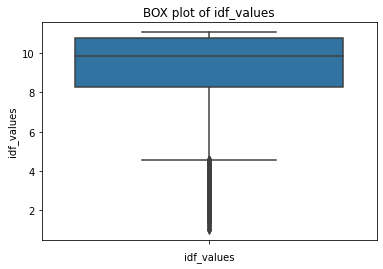

In [ ]:
sns.boxplot(y = "idf_values", data = tfidf_df)
plt.xlabel("idf_values")
plt.title("BOX plot of idf_values")

violin plot

Violin plot for idf values



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


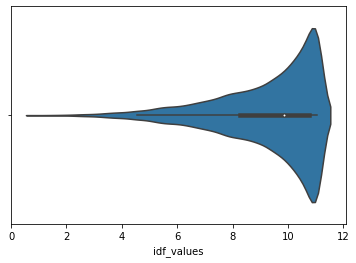

In [ ]:
print("Violin plot for idf values\n")
sns.violinplot(tfidf_df['idf_values'])
plt.show()

##Percentile Analysis

In [ ]:
print("0th percentile: ", np.percentile(tfidf_df['idf_values'],0))
print("10th percentile: ", np.percentile(tfidf_df['idf_values'],10))
print("20th percentile: ", np.percentile(tfidf_df['idf_values'],20))
print("30th percentile: ", np.percentile(tfidf_df['idf_values'],30))
print("40th percentile: ", np.percentile(tfidf_df['idf_values'],40))
print("50th percentile: ", np.percentile(tfidf_df['idf_values'],50))
print("60th percentile: ", np.percentile(tfidf_df['idf_values'],60))
print("70th percentile: ", np.percentile(tfidf_df['idf_values'],70))
print("80th percentile: ", np.percentile(tfidf_df['idf_values'],80))
print("90th percentile: ", np.percentile(tfidf_df['idf_values'],90))
print("100th percentile: ", np.percentile(tfidf_df['idf_values'],100))

0th percentile:  1.0075658420924976
10th percentile:  6.531075201980307
20th percentile:  7.824359367881314
30th percentile:  8.689356805367918
40th percentile:  9.382503985927864
50th percentile:  9.8525076151736
60th percentile:  10.36333323893959
70th percentile:  10.545654795733544
80th percentile:  10.768798347047754
90th percentile:  11.056480419499536
100th percentile:  11.056480419499536


###Number of Unique words in the corpus

In [ ]:
filter =   (tfidf_df['idf_values']>=2) & (tfidf_df['idf_values'] <=11.05)
tfidf_best = tfidf_df[filter]
print(tfidf_best.shape)

(23543, 2)


####Post Padding

In [ ]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
def encoding_padding(input_text, max_length):
    encoded_data = tokenizer.texts_to_sequences(input_text)
    padded_data = pad_sequences(encoded_data, maxlen=max_length, padding='post')
    return padded_data

#Tokenize:
Input data to layer should be integer. So, using tokenize inbuilt function, we will integer encode the text data.

In [ ]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
train_text = x_train["essay"].values.tolist()
test_text = x_test['essay'].values.tolist()
val_text = x_cv['essay'].values.tolist()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tfidf_best['words'].values.tolist())
vocab_size = len(tokenizer.word_index) + 1

max_length = 400
train_text_encode = encoding_padding(train_text,  max_length=max_length)
test_text_encode = encoding_padding(test_text, max_length=max_length)
val_text_encode = encoding_padding(val_text, max_length=max_length)

print(train_text_encode.shape)
print(test_text_encode.shape)
print(val_text_encode.shape)

(69918, 400)
(21850, 400)
(17480, 400)


In [ ]:
train_text_encode[0]

array([16051, 11854, 17900, 13705, 16677, 16112, 16346, 12651, 10763,
       10205, 10669,  8710,  3453,   881,   752,  6794, 13402, 15046,
       19571, 18533, 12054, 12488, 14064, 12651, 10763,  9381, 10337,
       12488,  8058, 13203, 10218,  8044,  1474, 17461,  1020,  1876,
       21297, 13128,  8909, 17621,  1712, 20852, 22794,  9209, 20237,
        2461,  7836, 18700,  8716,  6959,  3455, 21119,  6535, 10370,
       10622,  9216, 16954,  7836, 22645, 19343,  7174,  6012,  8316,
       13731, 19123,  6012, 11139,  6012, 16051, 12470, 19123, 16346,
       20219, 16506, 10084, 16681,  6958, 16501, 12619, 14358,  9167,
       11932, 12350, 10201, 12350, 19082, 20852, 22797,  9814, 16500,
        2461,  6959,  7834, 15962, 11932, 16112,  7836,  8583,  6535,
        3118,  8716,  9591,  1623,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

#Weight Matrix

In [ ]:
glove_vector = open("/content/drive/MyDrive/Lstm on donor choose/glove_vectors","rb")
glove_words = pickle.load(glove_vector)

In [ ]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_words.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)
embedding_matrix[10]

(23544, 300)


array([-4.9187e-01, -8.9405e-02, -1.1349e-01,  2.5081e-01,  1.7025e-01,
        4.4045e-02, -8.0568e-01, -5.3650e-02, -1.5190e-01,  3.2618e-01,
       -2.6259e-01,  7.9806e-01,  7.7951e-02, -1.5277e-01,  3.0831e-01,
        1.8557e-01, -5.0393e-02,  3.9665e-02, -1.5349e-01, -9.0685e-03,
        4.3312e-01, -1.8381e-01,  2.5506e-01,  3.4104e-01, -2.2033e-01,
       -1.5333e-02, -1.7249e-01,  2.6203e-01, -2.6015e-02,  6.9308e-01,
       -1.2871e-01, -1.1590e-01,  1.1784e-01,  3.8740e-01, -1.0099e-01,
       -1.1430e-01, -3.1958e-01, -1.9918e-01,  3.3425e-01,  1.4817e-01,
        6.2132e-01, -1.9276e-01,  2.3862e-01,  1.5748e-01,  3.4096e-01,
        5.6498e-01,  1.7457e-01, -8.1865e-02, -5.1860e-01, -2.7357e-01,
        2.1368e-01, -6.6864e-02, -4.3518e-01, -1.3831e-01, -3.5474e-01,
       -4.5110e-01, -1.1627e-01, -1.8612e-01,  4.7144e-01,  9.4884e-03,
        3.9908e-02,  5.0543e-02,  6.9555e-02,  5.7015e-01,  2.9583e-01,
        4.2223e-02, -7.1775e-02,  1.7495e-01,  7.3164e-02,  2.33

In [ ]:
vocab_size

23544

In [ ]:
train_text_encode.shape[1]

400

##Embedding layer for text data

In [ ]:
# Creating an input layer
input_essay = Input(shape=(train_text_encode.shape[1],), name='input_essay')
# Creating an embedding layer
x1 =Embedding(input_dim=vocab_size, output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], input_length=train_text_encode.shape[1], trainable=False, name='embed_essay')(input_essay)
# Creating LSTM layer
x1 = LSTM(128,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(x1)

layer_1 = Flatten()(x1)

###Concatenating all the flattened layers

In [ ]:
x_concat = concatenate([layer_1, layer_2, layer_3, layer_4, layer_5, layer_6, layer_7])

#<font color='red'>Keras Model-2</font>

- Activation :  {  hidden_layer : relu , output_layer : softmax  }
- optimizer :   { 'Adam'}
- loss      :   { 'categorical_crossentropy' }
- Batch_size :  {512}
- epoch      :  {10}

In [ ]:
x1 = Dense(100, activation="relu", kernel_initializer="he_normal" ,kernel_regularizer=regularizers.l2(0.001))(x_concat)
x1 = Dropout(0.5)(x1)
x1 = Dense(250,activation="relu",kernel_initializer="glorot_normal" ,kernel_regularizer=regularizers.l2(0.001))(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.5)(x1)
x1 = Dense(100,activation="relu", kernel_initializer="glorot_normal" ,kernel_regularizer=regularizers.l2(0.001))(x1)
output = Dense(2, activation='softmax', name='output')(x1)

model_2 = Model(inputs=[input_essay, input_state ,input_prefix,input_cat,
                       input_subcat ,input_grade ,num_feats ],outputs=[output])



print(model_2.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_essay (InputLayer)        [(None, 400)]        0                                            
__________________________________________________________________________________________________
embed_essay (Embedding)         (None, 400, 300)     7063200     input_essay[0][0]                
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
school_state (InputLayer)       [(None, 1)]          0                                            
____________________________________________________________________________________________

Getting all data into list

In [ ]:
#Getting all data into list
#for train data
train_data = [train_text_encode, train_prefix_encode, train_state_encode, train_grade_encode,
              train_cat_encode, train_subcat_encode, train_rem_input]
#for test data
test_data = [test_text_encode, test_prefix_encode, test_state_encode, test_grade_encode,
             test_cat_encode, test_subcat_encode, test_rem_input]
#cv data
val_data = [val_text_encode, val_prefix_encode, val_state_encode, val_grade_encode,
            val_cat_encode, val_subcat_encode, val_rem_input]

In [ ]:
checkpoint2 = ModelCheckpoint("model_2.h5",
                             monitor="val_auroc",
                             mode="max",
                             save_best_only = True,
                             verbose=1)
earlystop2 = EarlyStopping(monitor = 'val_auroc', 
                            mode="max",
                            min_delta = 0, 
                            patience = 3,
                            verbose = 1)

tensorboard2 = TensorBoard(log_dir='Model2_visualization')

callbacks_2 = [checkpoint2,earlystop2,tensorboard2]

In [ ]:
from keras.utils import np_utils

#np_utils.to_categorical is used to convert array of labeled data(from 0 to nb_classes-1) to one-hot vector.

y_train = np_utils.to_categorical(y_train, 2)
y_test = np_utils.to_categorical(y_test, 2)
y_cv = np_utils.to_categorical(y_cv, 2)

In [ ]:
y_cv.shape

(17480, 2)

In [ ]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auroc])

history1 = model_2.fit(train_data, y_train, batch_size=512, epochs=10, verbose=1,callbacks=callbacks_2, validation_data=(val_data, y_cv))

Epoch 1/10
137/137 [==============================] - 732s 5s/step - loss: 1.0989 - auroc: 0.6023 - val_loss: 0.8261 - val_auroc: 0.6988

Epoch 00001: val_auroc improved from -inf to 0.69881, saving model to model_2.h5
Epoch 2/10
137/137 [==============================] - 723s 5s/step - loss: 0.7547 - auroc: 0.6885 - val_loss: 0.7902 - val_auroc: 0.7218

Epoch 00002: val_auroc improved from 0.69881 to 0.72176, saving model to model_2.h5
Epoch 3/10
137/137 [==============================] - 706s 5s/step - loss: 0.6454 - auroc: 0.7106 - val_loss: 0.7441 - val_auroc: 0.7365

Epoch 00003: val_auroc improved from 0.72176 to 0.73648, saving model to model_2.h5
Epoch 4/10
137/137 [==============================] - 725s 5s/step - loss: 0.5820 - auroc: 0.7184 - val_loss: 0.6495 - val_auroc: 0.7368

Epoch 00004: val_auroc improved from 0.73648 to 0.73683, saving model to model_2.h5
Epoch 5/10
137/137 [==============================] - 744s 5s/step - loss: 0.5338 - auroc: 0.7268 - val_loss: 0.608

<font color='red'>plot epoch vs loss</font>

In [ ]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

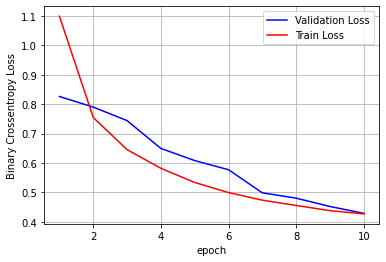

In [ ]:
%matplotlib inline
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')
x = list(range(1,11))
vy = history1.history['val_loss']
ty = history1.history['loss']
plt_dynamic(x, vy, ty, ax)

<font color='red'>auc-roc score</font>

43/43 [==============================] - 78s 2s/step - loss: 0.4272 - auroc: 0.7572
Test Loss: 0.42724213004112244
Test ROC-AUC score: 0.7571699619293213 



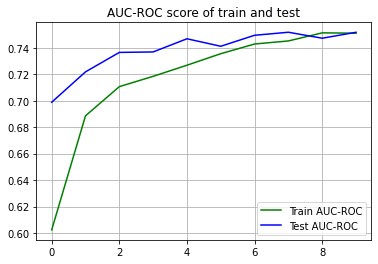

In [ ]:
# Evaluating test data
score_1 = model_2.evaluate(test_data, y_test, verbose = 1, batch_size = 512)
print('Test Loss:', score_1[0])
print('Test ROC-AUC score:', score_1[1], '\n')

# Plotting train and test auc roc score
plt.plot(history1.history['auroc'], 'g')
plt.plot(history1.history['val_auroc'], 'b')
plt.title("AUC-ROC score of train and test")
plt.legend({'Train AUC-ROC': 'g', 'Test AUC-ROC':'b'})
plt.grid()
plt.show()

###Observation:
- Test loss - 0.4272
- Test AUC-ROC - 0.7571

###Network Artitecture

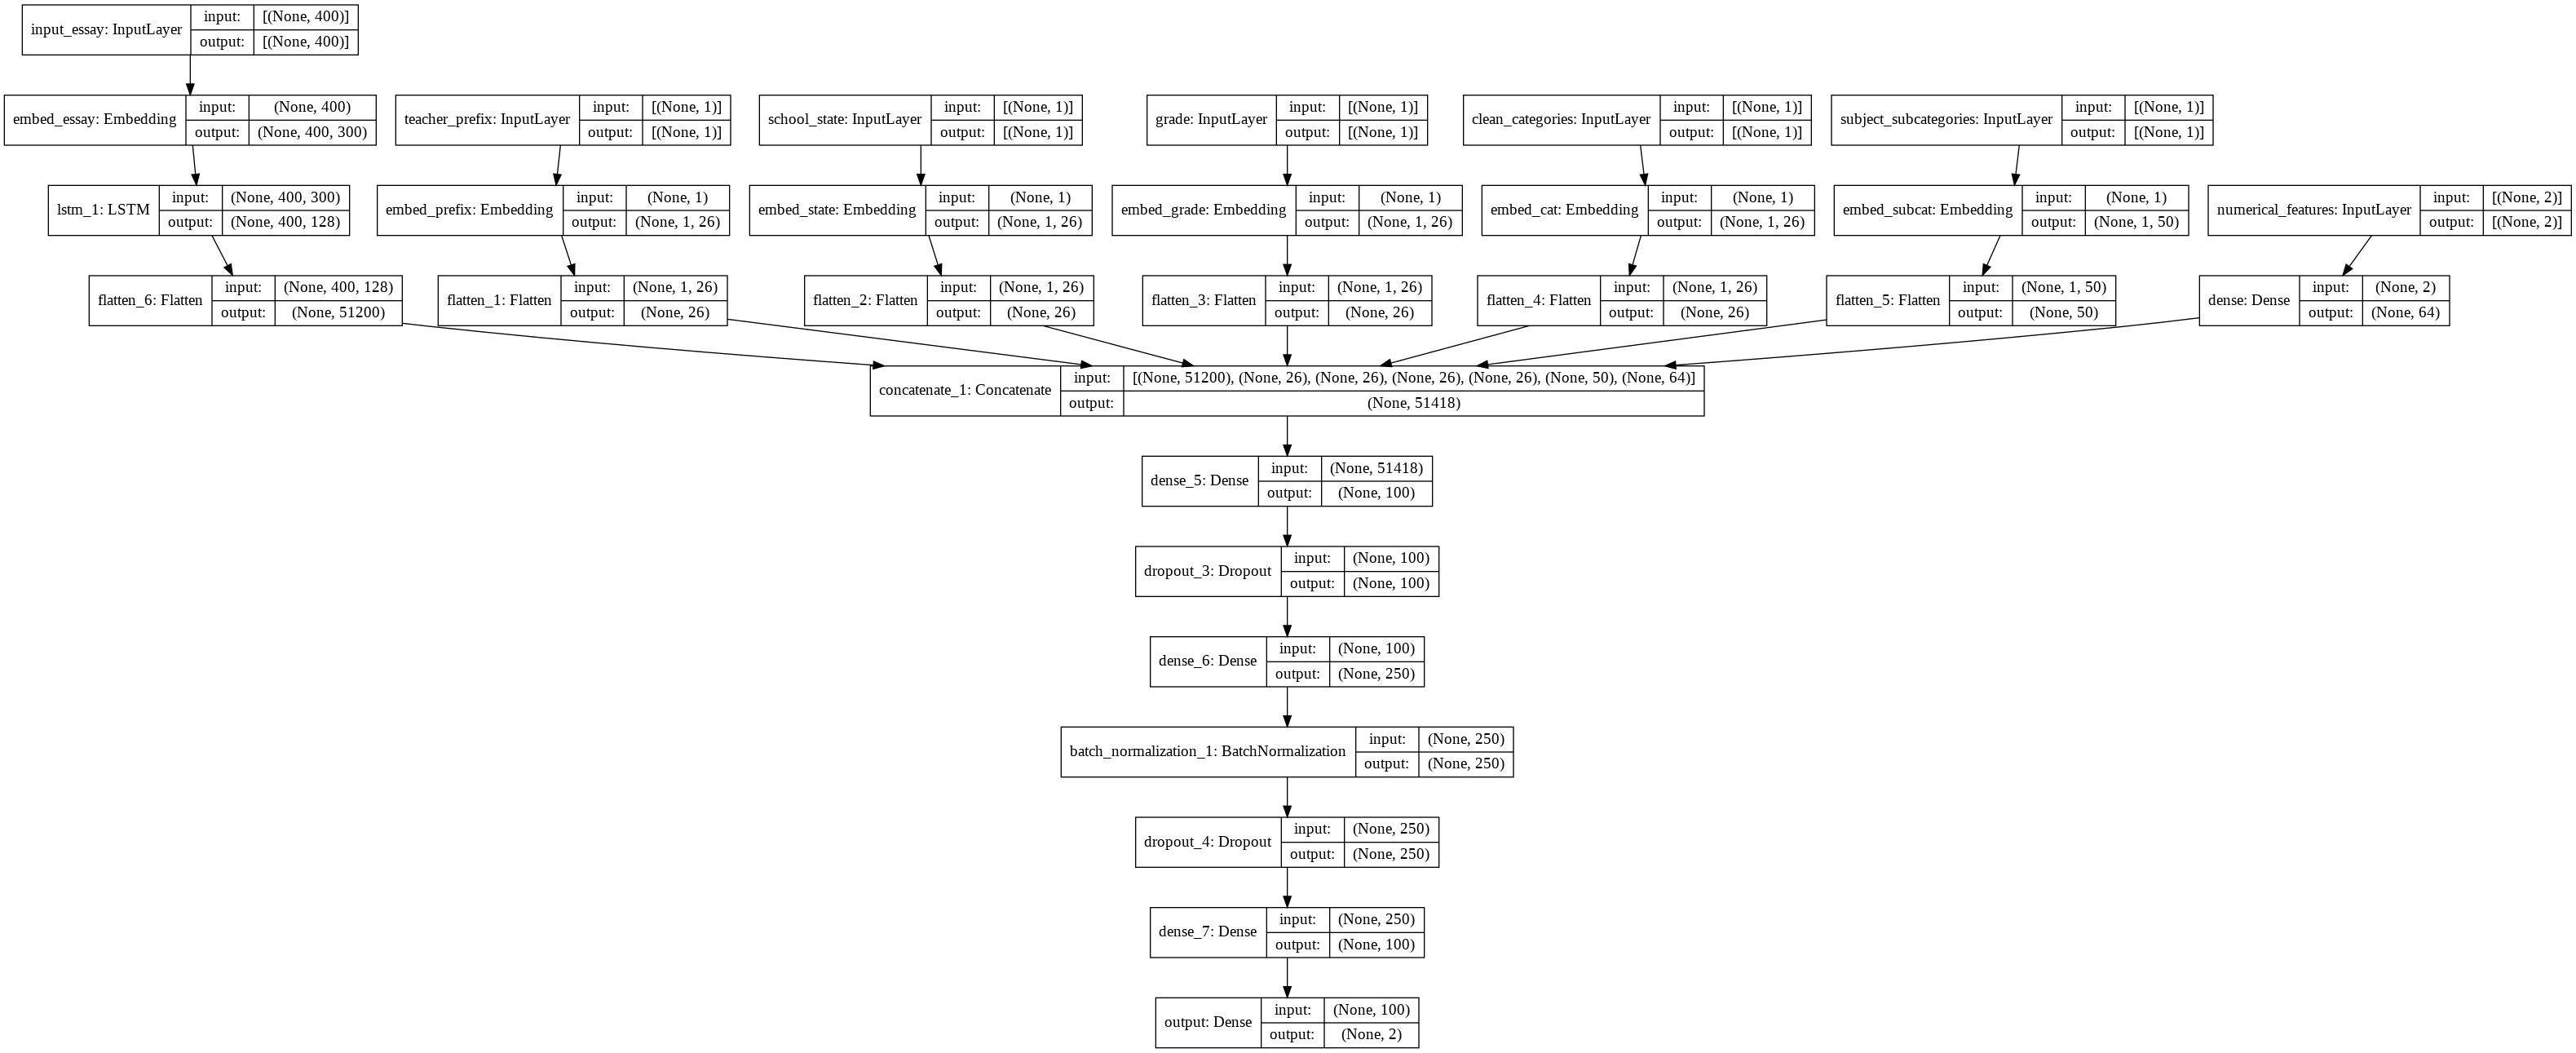

In [ ]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
import pydot_ng as pydot
from IPython.display import Image

plot_model(model_2, show_shapes = True, show_layer_names = True, to_file = 'model_2.png')

Image(retina = True, filename = 'model_2.png')

#<font color='red'>Keras Model-2.2</font>

- Activation :  {  hidden_layer : relu , output_layer : softmax  }same as model2.1 with different hidden number.
- optimizer :   { 'Adam'}
- loss      :   { 'categorical_crossentropy' }
- Batch_size :  {256}
- epoch      :  {10}

In [ ]:
# Creating an input layer
input_essay = Input(shape=(train_text_encode.shape[1],), name='input_essay')
# Creating an embedding layer
x1 =Embedding(input_dim=vocab_size, output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], input_length=train_text_encode.shape[1], trainable=False, name='embed_essay')(input_essay)
# Creating LSTM layer
x1 = LSTM(128,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(x1)

layer_1 = Flatten()(x1)

In [ ]:
x_concat = concatenate([layer_1, layer_2, layer_3, layer_4, layer_5, layer_6, layer_7])

In [ ]:
x1 = Dense(256, activation="relu", kernel_initializer="he_normal" ,kernel_regularizer=regularizers.l2(0.001))(x_concat)
x1 = Dropout(0.5)(x1)
x1 = Dense(128,activation="relu",kernel_initializer="glorot_normal" ,kernel_regularizer=regularizers.l2(0.001))(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.5)(x1)
x1 = Dense(64,activation="relu", kernel_initializer="glorot_normal" ,kernel_regularizer=regularizers.l2(0.001))(x1)
output = Dense(2, activation='softmax', name='output')(x1)

model_2 = Model(inputs=[input_essay, input_state ,input_prefix,input_cat,
                       input_subcat ,input_grade ,num_feats ],outputs=[output])



print(model_2.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_essay (InputLayer)        [(None, 400)]        0                                            
__________________________________________________________________________________________________
embed_essay (Embedding)         (None, 400, 300)     7063200     input_essay[0][0]                
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
school_state (InputLayer)       [(None, 1)]          0                                            
____________________________________________________________________________________________

In [ ]:
#Getting all data into list
#for train data
train_data = [train_text_encode, train_prefix_encode, train_state_encode, train_grade_encode,
              train_cat_encode, train_subcat_encode, train_rem_input]
#for test data
test_data = [test_text_encode, test_prefix_encode, test_state_encode, test_grade_encode,
             test_cat_encode, test_subcat_encode, test_rem_input]
#cv data
val_data = [val_text_encode, val_prefix_encode, val_state_encode, val_grade_encode,
            val_cat_encode, val_subcat_encode, val_rem_input]

In [ ]:
checkpoint2 = ModelCheckpoint("model_2.h5",
                             monitor="val_auroc",
                             mode="max",
                             save_best_only = True,
                             verbose=1)
earlystop2 = EarlyStopping(monitor = 'val_auroc', 
                            mode="max",
                            min_delta = 0, 
                            patience = 2,
                            verbose = 1)

tensorboard2 = TensorBoard(log_dir='Model2_visualization')

callbacks_2 = [checkpoint2,earlystop2,tensorboard2]

In [ ]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auroc])

history1 = model_2.fit(train_data, y_train, batch_size=256, epochs=10, verbose=1,callbacks=callbacks_2, validation_data=(val_data, y_cv))

Epoch 1/10
274/274 [==============================] - 59s 189ms/step - loss: 1.0549 - auroc: 0.5930 - val_loss: 0.8240 - val_auroc: 0.6972

Epoch 00001: val_auroc improved from -inf to 0.69715, saving model to model_2.h5
Epoch 2/10
274/274 [==============================] - 50s 181ms/step - loss: 0.6533 - auroc: 0.6763 - val_loss: 0.6171 - val_auroc: 0.7151

Epoch 00002: val_auroc improved from 0.69715 to 0.71510, saving model to model_2.h5
Epoch 3/10
274/274 [==============================] - 51s 186ms/step - loss: 0.5552 - auroc: 0.7025 - val_loss: 0.5846 - val_auroc: 0.7352

Epoch 00003: val_auroc improved from 0.71510 to 0.73516, saving model to model_2.h5
Epoch 4/10
274/274 [==============================] - 51s 186ms/step - loss: 0.4999 - auroc: 0.7208 - val_loss: 0.4879 - val_auroc: 0.7380

Epoch 00004: val_auroc improved from 0.73516 to 0.73803, saving model to model_2.h5
Epoch 5/10
274/274 [==============================] - 51s 186ms/step - loss: 0.4670 - auroc: 0.7250 - val_l

<font color='red'>plot epoch vs loss</font>

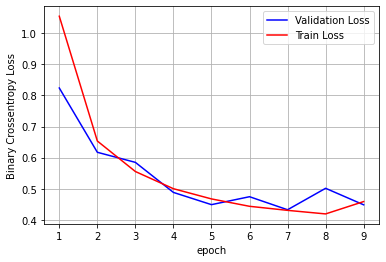

In [ ]:
%matplotlib inline
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')
x = list(range(1,10))
vy = history1.history['val_loss']
ty = history1.history['loss']
plt_dynamic(x, vy, ty, ax)

<font color='red'>auc-roc score</font>

43/43 [==============================] - 4s 97ms/step - loss: 0.4480 - auroc: 0.4117
Test Loss: 0.4480125904083252
Test ROC-AUC score: 0.41168510913848877 



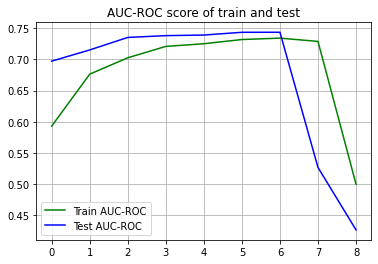

In [ ]:
# Evaluating test data
score_1 = model_2.evaluate(test_data, y_test, verbose = 1, batch_size = 512)
print('Test Loss:', score_1[0])
print('Test ROC-AUC score:', score_1[1], '\n')

# Plotting train and test auc roc score
plt.plot(history1.history['auroc'], 'g')
plt.plot(history1.history['val_auroc'], 'b')
plt.title("AUC-ROC score of train and test")
plt.legend({'Train AUC-ROC': 'g', 'Test AUC-ROC':'b'})
plt.grid()
plt.show()

#<font color='red'>Keras Model-2.3</font>

- Activation :  {  hidden_layer : relu,sigmoid , output_layer : softmax  }with different hidden layer and recuurent dropout.
- optimizer :   { Adam(0.0005, decay=1e-6)}
- loss      :   { binary_crossentropy' }
- Batch_size :  {850}
- epoch      :  {10}

In [ ]:
# Creating an input layer
input_essay = Input(shape=(train_text_encode.shape[1],), name='input_essay')
# Creating an embedding layer
x1 =Embedding(input_dim=vocab_size, output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], input_length=train_text_encode.shape[1], trainable=False, name='embed_essay')(input_essay)
# Creating LSTM layer
x1 = LSTM(100,recurrent_dropout=0.5,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(x1)

layer_1 = Flatten()(x1)

In [ ]:
x_concat = concatenate([layer_1, layer_2, layer_3, layer_4, layer_5, layer_6, layer_7])

In [ ]:
x = Dense(50, activation="relu", kernel_initializer="he_normal" ,kernel_regularizer=regularizers.l2(0.001))(x_concat)
x = Dropout(0.25)(x)
x = Dense(200,activation="relu",kernel_initializer="glorot_normal" ,kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(80,activation="sigmoid", kernel_initializer="glorot_normal" ,kernel_regularizer=regularizers.l2(0.001))(x)
output = Dense(2, activation='softmax', name='output')(x)

model2_1 = Model(inputs=[input_essay, input_state ,input_prefix,input_cat,
                       input_subcat ,input_grade ,num_feats ],outputs=[output])



print(model2_1.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_essay (InputLayer)        [(None, 400)]        0                                            
__________________________________________________________________________________________________
embed_essay (Embedding)         (None, 400, 300)     7063200     input_essay[0][0]                
__________________________________________________________________________________________________
teacher_prefix (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
school_state (InputLayer)       [(None, 1)]          0                                            
____________________________________________________________________________________________

In [ ]:
checkpoint2 = ModelCheckpoint("model2_1.h5",
                             monitor="val_auroc",
                             mode="max",
                             save_best_only = True,
                             verbose=1)
earlystop2 = EarlyStopping(monitor = 'val_auroc', 
                            mode="max",
                            min_delta = 0, 
                            patience = 2,
                            verbose = 1)

tensorboard2 = TensorBoard(log_dir='model2_1_visualization')

callbacks_2 = [checkpoint2,earlystop2,tensorboard2]

In [ ]:
from tensorflow.keras import optimizers
model2_1.compile(optimizer=optimizers.Adam(0.0005, decay=1e-6), loss='binary_crossentropy', metrics=[auroc])
history2_1= model2_1.fit(train_data, y_train, batch_size=850, epochs=10, verbose=1,callbacks=callbacks_2, validation_data=(val_data, y_cv))

Epoch 1/10
83/83 [==============================] - 161s 2s/step - loss: 0.9378 - auroc: 0.5799 - val_loss: 0.6630 - val_auroc: 0.6898

Epoch 00001: val_auroc improved from -inf to 0.68978, saving model to model2_1.h5
Epoch 2/10
83/83 [==============================] - 142s 2s/step - loss: 0.5649 - auroc: 0.6925 - val_loss: 0.5182 - val_auroc: 0.7063

Epoch 00002: val_auroc improved from 0.68978 to 0.70634, saving model to model2_1.h5
Epoch 3/10
83/83 [==============================] - 145s 2s/step - loss: 0.4797 - auroc: 0.7071 - val_loss: 0.4691 - val_auroc: 0.7178

Epoch 00003: val_auroc improved from 0.70634 to 0.71776, saving model to model2_1.h5
Epoch 4/10
83/83 [==============================] - 146s 2s/step - loss: 0.4437 - auroc: 0.7187 - val_loss: 0.4553 - val_auroc: 0.7238

Epoch 00004: val_auroc improved from 0.71776 to 0.72383, saving model to model2_1.h5
Epoch 5/10
83/83 [==============================] - 141s 2s/step - loss: 0.4236 - auroc: 0.7260 - val_loss: 0.4313 - va

<font color='red'>plot epoch vs loss</font>

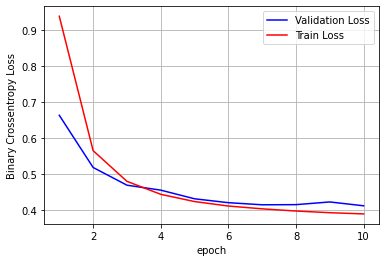

In [ ]:
%matplotlib inline
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')
x = list(range(1,11))
vy = history2_1.history['val_loss']
ty = history2_1.history['loss']
plt_dynamic(x, vy, ty, ax)

<font color='red'>auc-roc score</font>

26/26 [==============================] - 8s 312ms/step - loss: 0.4093 - auroc: 0.7426
Test Loss: 0.40928637981414795
Test ROC-AUC score: 0.7425810694694519 



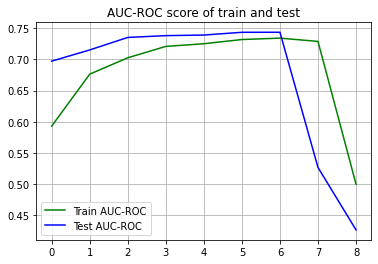

In [ ]:
# Evaluating test data
score_1 = model2_1.evaluate(test_data, y_test, verbose = 1, batch_size = 850)
print('Test Loss:', score_1[0])
print('Test ROC-AUC score:', score_1[1], '\n')

# Plotting train and test auc roc score
plt.plot(history1.history['auroc'], 'g')
plt.plot(history1.history['val_auroc'], 'b')
plt.title("AUC-ROC score of train and test")
plt.legend({'Train AUC-ROC': 'g', 'Test AUC-ROC':'b'})
plt.grid()
plt.show()

#Task-3:

- __input_seq_total_text_data__: <br>
<pre>
    . Use text column('essay'), and use the Embedding layer to get word vectors. <br>
    . Use given predefined glove word vectors, don't train any word vectors. <br>
    . Use LSTM that is given above, get the LSTM output and Flatten that output. <br>
    . You are free to preprocess the input text as you needed. <br>
</pre>
- __Other_than_text_data__:<br>
<pre>
    . Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors <br>
    . Neumerical values and use <a href='https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions'>CNN1D</a> as shown in above figure. <br>
    . You are free to choose all CNN parameters like kernel sizes, stride.<br>
    
</pre>

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png

In [ ]:
x_train.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'essay', 'price'],
      dtype='object')

#TEXT DATA
###1) school_state

In [ ]:
# Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors
# Neumerical values

# One hot encoding of Categorical Feature
# - school_state : categorical data
vectorizer = CountVectorizer()
vectorizer.fit(x_train['school_state'].values)# Training

x_train_school_state_ohe = vectorizer.transform(x_train['school_state'].values)
x_cv_school_state_ohe = vectorizer.transform(x_cv['school_state'].values)
x_test_school_state_ohe = vectorizer.transform(x_test['school_state'].values)

school_state_features = vectorizer.get_feature_names()
print(vectorizer.get_feature_names())
print('*'*100)
print(x_train_school_state_ohe.shape, y_train.shape)
print(x_cv_school_state_ohe.shape, y_cv.shape)
print(x_test_school_state_ohe.shape, y_test.shape)

['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
****************************************************************************************************
(69918, 51) (69918, 2)
(17480, 51) (17480, 2)
(21850, 51) (21850, 2)


###2) teacher_prefix

In [ ]:
# Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors
# Neumerical values

# One hot encoding of Categorical Feature
# - teacher_prefix : categorical data
vectorizer = CountVectorizer()
vectorizer.fit(x_train['teacher_prefix'].values)# Training

x_train_teacher_prefix_ohe = vectorizer.transform(x_train['teacher_prefix'].values)
x_cv_teacher_prefix_ohe = vectorizer.transform(x_cv['teacher_prefix'].values)
x_test_teacher_prefix_ohe = vectorizer.transform(x_test['teacher_prefix'].values)

teacher_prefix_features = vectorizer.get_feature_names()
print(vectorizer.get_feature_names())
print('*'*100)
print(x_train_teacher_prefix_ohe.shape, y_train.shape)
print(x_cv_teacher_prefix_ohe.shape, y_cv.shape)
print(x_test_teacher_prefix_ohe.shape, y_test.shape)

['dr', 'mr', 'mrs', 'ms', 'teacher']
****************************************************************************************************
(69918, 5) (69918, 2)
(17480, 5) (17480, 2)
(21850, 5) (21850, 2)


###3) project_grade_category

In [ ]:
# Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors
# Neumerical values

# One hot encoding of Categorical Feature
# - project_grade_category : categorical data
vectorizer = CountVectorizer()
vectorizer.fit(x_train['project_grade_category'].values)# Training

x_train_project_grade_category_ohe = vectorizer.transform(x_train['project_grade_category'].values)
x_cv_project_grade_category_ohe = vectorizer.transform(x_cv['project_grade_category'].values)
x_test_project_grade_category_ohe = vectorizer.transform(x_test['project_grade_category'].values)

project_grade_category_features = vectorizer.get_feature_names()
print(vectorizer.get_feature_names())
print('*'*100)
print(x_train_project_grade_category_ohe.shape, y_train.shape)
print(x_cv_project_grade_category_ohe.shape, y_cv.shape)
print(x_test_project_grade_category_ohe.shape, y_test.shape)

['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
****************************************************************************************************
(69918, 4) (69918, 2)
(17480, 4) (17480, 2)
(21850, 4) (21850, 2)


###4) clean_categories

In [ ]:
# Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors
# Neumerical values

# One hot encoding of Categorical Feature
# - clean_categories : categorical data
vectorizer = CountVectorizer()
vectorizer.fit(x_train['clean_categories'].values)# Training

x_train_clean_categories_ohe = vectorizer.transform(x_train['clean_categories'].values)
x_cv_clean_categories_ohe = vectorizer.transform(x_cv['clean_categories'].values)
x_test_clean_categories_ohe = vectorizer.transform(x_test['clean_categories'].values)

project_grade_category_features = vectorizer.get_feature_names()
print(vectorizer.get_feature_names())
print('*'*100)
print(x_train_clean_categories_ohe.shape, y_train.shape)
print(x_cv_clean_categories_ohe.shape, y_cv.shape)
print(x_test_clean_categories_ohe.shape, y_test.shape)

['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
****************************************************************************************************
(69918, 9) (69918, 2)
(17480, 9) (17480, 2)
(21850, 9) (21850, 2)


###5) clean_subcategories

In [ ]:
# Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors
# Neumerical values

# One hot encoding of Categorical Feature
# - clean_subcategories : categorical data
vectorizer = CountVectorizer()
vectorizer.fit(x_train['clean_subcategories'].values)# Training

x_train_clean_subcategories_ohe = vectorizer.transform(x_train['clean_subcategories'].values)
x_cv_clean_subcategories_ohe = vectorizer.transform(x_cv['clean_subcategories'].values)
x_test_clean_subcategories_ohe = vectorizer.transform(x_test['clean_subcategories'].values)

project_grade_subcategory_features = vectorizer.get_feature_names()
print(vectorizer.get_feature_names())
print('*'*100)
print(x_train_clean_subcategories_ohe.shape, y_train.shape)
print(x_cv_clean_subcategories_ohe.shape, y_cv.shape)
print(x_test_clean_subcategories_ohe.shape, y_test.shape)

['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']
****************************************************************************************************
(69918, 30) (69918, 2)
(17480, 30) (17480, 2)
(21850, 30) (21850, 2)


#Numerical Data
1- price

In [ ]:
# You no need to perform standardization/normalization on numerical data, 
# because you will classify data by using gini impurity in decision tree classifier.
# - price,teacher_number_of_previously_posted_projects   : numerical

x_train_price_input_norm = x_train['price'].values.reshape(-1,1)
x_cv_price_input_norm = x_cv['price'].values.reshape(-1,1)
x_test_price_input_norm = x_test['price'].values.reshape(-1,1)

print("After vectorizations")
print("*"*100)
print(x_train_price_input_norm.shape, y_train.shape)
print(x_cv_price_input_norm.shape, y_cv.shape)
print(x_test_price_input_norm.shape, y_test.shape)

After vectorizations
****************************************************************************************************
(69918, 1) (69918, 2)
(17480, 1) (17480, 2)
(21850, 1) (21850, 2)


2 - teacher_number_of_previously_posted_projects 

In [ ]:
# You no need to perform standardization/normalization on numerical data, 
# because you will classify data by using gini impurity in decision tree classifier.
# - price,teacher_number_of_previously_posted_projects   : numerical

x_train_teacher_number_of_previously_posted_projects_input_norm = x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
x_cv_teacher_number_of_previously_posted_projects_input_norm = x_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
x_test_teacher_number_of_previously_posted_projects_input_norm = x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)

print("After vectorizations")
print("*"*100)
print(x_train_teacher_number_of_previously_posted_projects_input_norm.shape, y_train.shape)
print(x_cv_teacher_number_of_previously_posted_projects_input_norm.shape, y_cv.shape)
print(x_test_teacher_number_of_previously_posted_projects_input_norm.shape, y_test.shape)

After vectorizations
****************************************************************************************************
(69918, 1) (69918, 2)
(17480, 1) (17480, 2)
(21850, 1) (21850, 2)


### Stacking one on top of the other in the form of a dense matrix

In [ ]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
# X = hstack((categories_one_hot, sub_categories_one_hot, text_bow, price_standardized))
# X.shape

X_train_final = hstack((x_train_school_state_ohe, x_train_clean_categories_ohe,x_train_clean_subcategories_ohe, x_train_project_grade_category_ohe,x_train_teacher_prefix_ohe,x_train_price_input_norm,x_train_teacher_number_of_previously_posted_projects_input_norm)).tocsr()

X_cv_final = hstack((x_cv_school_state_ohe, x_cv_clean_categories_ohe,x_cv_clean_subcategories_ohe, x_cv_project_grade_category_ohe, x_cv_teacher_prefix_ohe,x_cv_price_input_norm ,x_cv_teacher_number_of_previously_posted_projects_input_norm)).tocsr()

X_test_final = hstack((x_test_school_state_ohe, x_test_clean_categories_ohe,x_test_clean_subcategories_ohe, x_test_project_grade_category_ohe, x_test_teacher_prefix_ohe,x_test_price_input_norm,x_test_teacher_number_of_previously_posted_projects_input_norm)).tocsr()

In [ ]:
print(X_train_final.shape)
print(X_cv_final.shape)
print(X_test_final.shape)

(69918, 101)
(17480, 101)
(21850, 101)



Adding new dimension as '2' as we want a 2 Dimensional output

In [ ]:
train_final = X_train_final.todense()
cv_final = X_cv_final.todense()
test_final = X_test_final.todense()

In [ ]:
X_train_final_new = np.resize(train_final,new_shape=(69918,101,1))
X_cv_final_new = np.resize(cv_final,new_shape=(17480,101,1))
X_test_final_new = np.resize(test_final,new_shape=(21850,101,1))

In [ ]:
X_train_final_new.shape

(69918, 101, 1)

In [ ]:
print("Final Train data shape",X_train_final_new.shape)
print("Final cv data shape",X_cv_final_new.shape)
print("Final Test data shape",X_test_final_new.shape)

Final Train data shape (69918, 101, 1)
Final cv data shape (17480, 101, 1)
Final Test data shape (21850, 101, 1)


In [ ]:
from keras.utils import np_utils

#np_utils.to_categorical is used to convert array of labeled data(from 0 to nb_classes-1) to one-hot vector.

y_train = np_utils.to_categorical(y_train, 2)
y_test = np_utils.to_categorical(y_test, 2)
y_cv = np_utils.to_categorical(y_cv, 2)

In [ ]:
y_cv.shape

(17480, 2)

#<font color='red'>Keras Model-3</font>
###<font color='Blue'>1) LSTM for TEXT DATA</font>
###<font color='Blue'>2) CONV1D for OTHER THAN TEXT DATA</font>
###<font color='Blue'>3) Dense Layer after Concatenating both</font>

In [ ]:
train_text_encode.shape[1]

400

In [ ]:
# Creating an input layer
input_essay = Input(shape=(train_text_encode.shape[1],), name='input_essay')
# Creating an embedding layer
x1 =Embedding(input_dim=vocab_size, output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], input_length=train_text_encode.shape[1], trainable=False, name='embed_essay')(input_essay)
# Creating LSTM layer
x1 = LSTM(100,recurrent_dropout=0.5,kernel_regularizer=regularizers.l2(0.001),return_sequences=True)(x1)

layer_1 = Flatten()(x1)

In [ ]:
from keras.layers import MaxPooling1D

input_without_text  = Input(shape=(101,1), name='without_text')
convo = Conv1D(512 , 3 , activation='relu' ,  kernel_initializer=he_normal(seed=None) , padding='valid')(input_without_text)
convo = Conv1D(256 , 3 , activation='relu' ,  kernel_initializer=he_normal(seed=None) , padding='valid')(convo)
convo = Conv1D(128 , 3 , activation='relu' ,  kernel_initializer=he_normal(seed=None) , padding='valid')(convo)
convo = Conv1D(64 , 3 , activation='relu' ,  kernel_initializer=he_normal(seed=None) , padding='valid')(convo)
flatten_without_text = Flatten()(convo)
x_concat = concatenate([layer_1 , flatten_without_text])

x = Dense(256, activation="relu", kernel_initializer="he_normal" ,kernel_regularizer=regularizers.l2(0.001))(x_concat)
x=Dropout(0.5)(x)
x = Dense(128,activation="sigmoid",kernel_initializer="glorot_normal" ,kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x=Dropout(0.5)(x)
x = Dense(64,activation="relu", kernel_initializer="he_normal" ,kernel_regularizer=regularizers.l2(0.001))(x)
output = Dense(2, activation='softmax', name='output')(x)
model_3 = Model(inputs=[input_essay, input_without_text],outputs=[output])

print(model_3.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
without_text (InputLayer)       [(None, 101, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 99, 512)      2048        without_text[0][0]               
__________________________________________________________________________________________________
input_essay (InputLayer)        [(None, 400)]        0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 97, 256)      393472      conv1d_4[0][0]                   
______________________________________________________________________________________________

#Network Artitecture

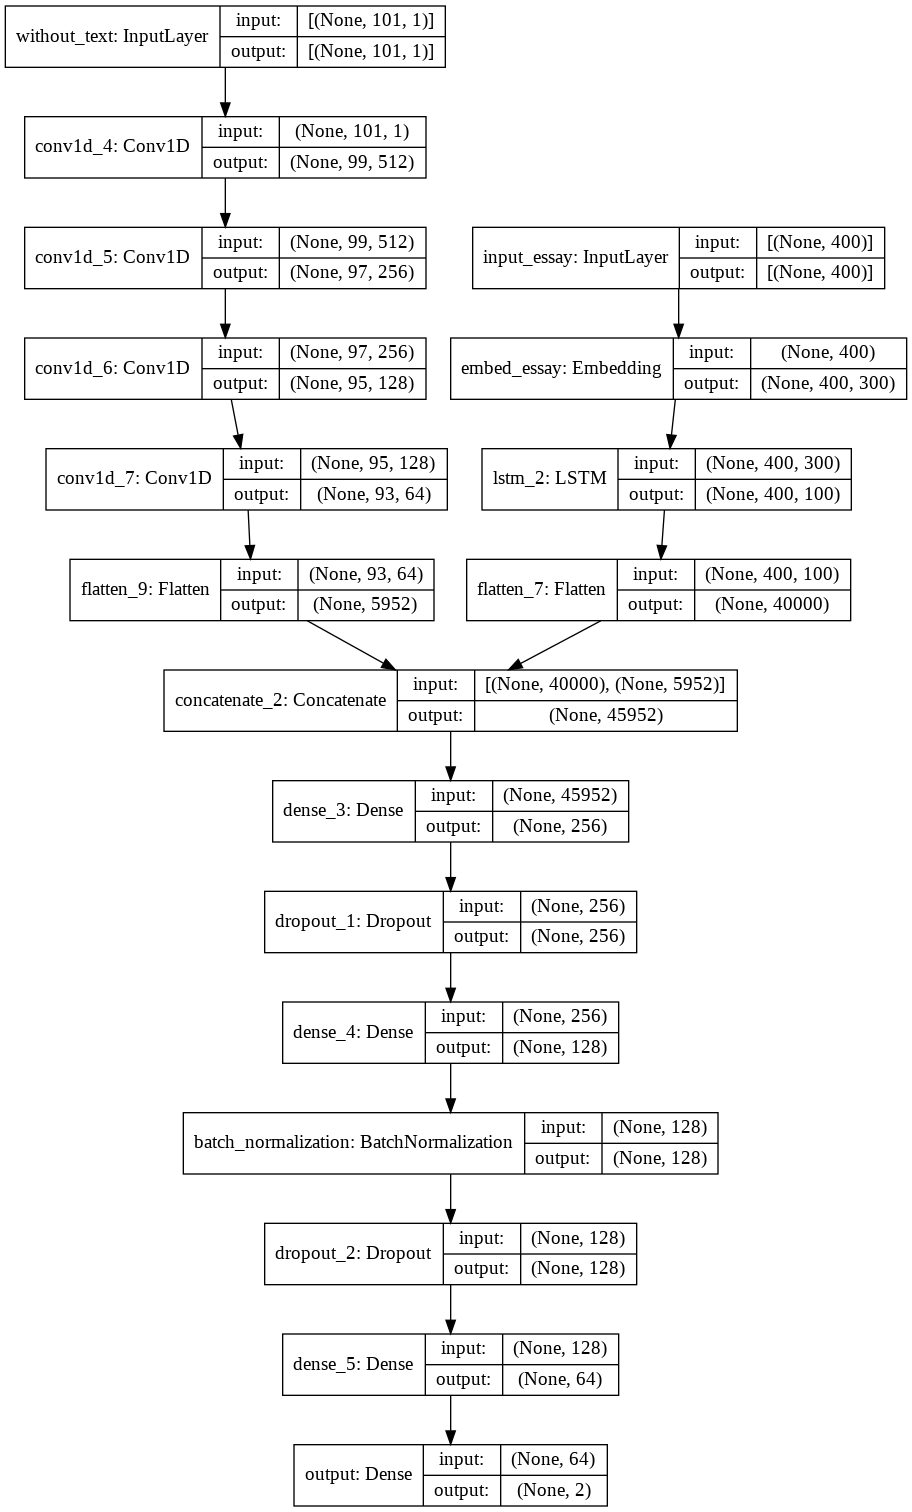

In [ ]:
# https://github.com/mmortazavi/EntityEmbedding-Working_Example/blob/master/EntityEmbedding.ipynb

import pydot_ng as pydot
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model_3, show_shapes = True, show_layer_names = True, to_file = 'model_3.png')

Image(retina = True, filename = 'model_3.png')

In [ ]:
train_text_encode.shape

(69918, 400)

###getting into one list

In [ ]:
train_data_3 = [train_text_encode,X_train_final_new]
cv_data_3 = [val_text_encode,X_cv_final_new]
test_data_3 = [test_text_encode,X_test_final_new]

In [ ]:
checkpoint3_1 = ModelCheckpoint("model_3.h5",
                             monitor="val_auroc",
                             mode="max",
                             save_best_only = True,
                             verbose=1)
earlystop3_1 = EarlyStopping(monitor = 'val_auroc', 
                            mode="max",
                            min_delta = 0, 
                            patience = 3,
                            verbose = 1)
tensorboard3_1 = TensorBoard(log_dir='Model3_visualization')

callbacks_3_1 = [checkpoint3_1,earlystop3_1,tensorboard3_1]

In [ ]:
from tensorflow.keras import optimizers
model_3.compile(optimizer=optimizers.Adam(0.0005, decay=1e-6),loss='binary_crossentropy', metrics=[auroc])

history_3= model_3.fit(train_data_3, y_train, batch_size=850, epochs=10, verbose=1,callbacks=callbacks_3_1, validation_data=(cv_data_3, y_cv))

Epoch 1/10
83/83 [==============================] - 1362s 16s/step - loss: 1.0672 - auroc: 0.5316 - val_loss: 0.7536 - val_auroc: 0.6160

Epoch 00001: val_auroc improved from -inf to 0.61596, saving model to model_3.h5
Epoch 2/10
83/83 [==============================] - 1291s 16s/step - loss: 0.7104 - auroc: 0.5874 - val_loss: 0.6312 - val_auroc: 0.6815

Epoch 00002: val_auroc improved from 0.61596 to 0.68146, saving model to model_3.h5
Epoch 3/10
83/83 [==============================] - 1328s 16s/step - loss: 0.6272 - auroc: 0.6512 - val_loss: 0.5766 - val_auroc: 0.7160

Epoch 00003: val_auroc improved from 0.68146 to 0.71602, saving model to model_3.h5
Epoch 4/10
83/83 [==============================] - 1325s 16s/step - loss: 0.5824 - auroc: 0.6857 - val_loss: 0.5441 - val_auroc: 0.7227

Epoch 00004: val_auroc improved from 0.71602 to 0.72266, saving model to model_3.h5
Epoch 5/10
83/83 [==============================] - 1277s 15s/step - loss: 0.5495 - auroc: 0.7048 - val_loss: 0.541

<font color='red'>Plot epoch vs loss</font>

In [ ]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

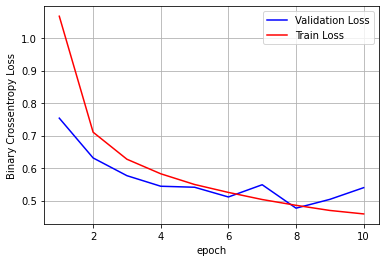

In [ ]:
%matplotlib inline
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')
x = list(range(1,11))
vy = history_3.history['val_loss']
ty = history_3.history['loss']
plt_dynamic(x, vy, ty, ax)

<font color='red'>auc-roc score</font>

26/26 [==============================] - 107s 4s/step - loss: 0.5370 - auroc: 0.7483
Test Loss: 0.5370233654975891
Test ROC-AUC score: 0.7483065724372864 



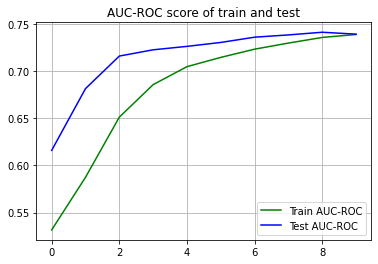

In [ ]:
# Evaluating test data
score_1 = model_3.evaluate(test_data_3, y_test, verbose = 1, batch_size = 850)
print('Test Loss:', score_1[0])
print('Test ROC-AUC score:', score_1[1], '\n')

# Plotting train and test auc roc score
plt.plot(history_3.history['auroc'], 'g')
plt.plot(history_3.history['val_auroc'], 'b')
plt.title("AUC-ROC score of train and test")
plt.legend({'Train AUC-ROC': 'g', 'Test AUC-ROC':'b'})
plt.grid()
plt.show()

#Observation:

In [ ]:
from prettytable import PrettyTable

a = PrettyTable()

a.field_names = ['S.No', 'Model', 'Optimizer','val_loss','val_auroc' ,'Test Loss', 'Test AUC-ROC']

a.add_row([1, 'Model- 1.1', 'adam', 0.4541,0.7538,0.4524, 0.7566])
a.add_row([1, 'Model- 1.2', 'adam', 0.6848,0.6284,0.6632, 0.5064])
a.add_row([1, 'Model- 1.3', 'adam', 0.9218,0.7299,0.9231, 0.7278])
a.add_row([2, 'Model- 2.1', 'adam',0.4289,0.7517 ,0.4272, 0.7571])
a.add_row([2, 'Model- 2.2', 'adam',0.3893,0.7504 ,0.4481, 0.7434])
a.add_row([2, 'Model- 2.3', 'adam',0.4118,0.7327 ,0.4093, 0.7426])
a.add_row([3, 'Model- 3', 'adam', 0.4651 ,07413.,0.5370 ,0.7483])

print(a.get_string(title = "LSTM on Donors Result"))

+---------------------------------------------------------------------------------+
|                              LSTM on Donors Result                              |
+------+------------+-----------+----------+-----------+-----------+--------------+
| S.No |   Model    | Optimizer | val_loss | val_auroc | Test Loss | Test AUC-ROC |
+------+------------+-----------+----------+-----------+-----------+--------------+
|  1   | Model- 1.1 |    adam   |  0.4541  |   0.7538  |   0.4524  |    0.7566    |
|  1   | Model- 1.2 |    adam   |  0.6848  |   0.6284  |   0.6632  |    0.5064    |
|  1   | Model- 1.3 |    adam   |  0.9218  |   0.7299  |   0.9231  |    0.7278    |
|  2   | Model- 2.1 |    adam   |  0.4289  |   0.7517  |   0.4272  |    0.7571    |
|  2   | Model- 2.2 |    adam   |  0.3893  |   0.7504  |   0.4481  |    0.7434    |
|  2   | Model- 2.3 |    adam   |  0.4118  |   0.7327  |   0.4093  |    0.7426    |
|  3   |  Model- 3  |    adam   |  0.4651  |   7413.0  |   0.537   |    0.74

#refernce;
https://github.com/Dharaniraj1997/LSTM-on-DonorsChoose/blob/main/LSTM%20on%20DonorsChoose.ipynb

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/